In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os.path as path

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Reshape
import tensorflow_decision_forests as tfdf

2023-08-24 17:47:26.601937: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 17:47:26.667675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 17:47:27.301951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ROOT_DIR = path.abspath("../../data/datasets")

def csvfile(root_dir, train):
    # UNSW_NB15_testing-set.csv is actually more suitable for training because it has more data
    return path.join(root_dir, "UNSW_NB15_" + ("testing" if train else "training") + "-set.csv")

train = pd.read_csv(csvfile(ROOT_DIR, True))
test = pd.read_csv(csvfile(ROOT_DIR, False))

## Config

In [3]:
NUM_CLIENTS = 3
NUM_ROUNDS = 30
S_ADDR = "127.0.0.1:8080"
DEBUG = 0
LOCAL_DEBUG = False
TEST_CENTRALISED = 0
MODEL_CKPT_DIR=path.abspath("../../model_ckpt/")
RUNS = 10

## Global Vars

In [4]:
histories = []

## Start to Preprocess

In [5]:
list_drop = ['id', 'attack_cat']
train = train.drop(list_drop, axis=1)
test = test.drop(list_drop, axis=1)

In [6]:
df = pd.concat([train, test])
len(df)

257673

## Removing outliers

In [7]:
# Select numeric categories
def rm_outliers(df_in: pd.DataFrame):
    result= df_in.copy()
    df_numeric = df_in.select_dtypes(include=[np.number])
    df_numeric.describe(include='all')

    # Remove outliers
    for feature in df_numeric.columns:
        if DEBUG == 1:
            print(feature)
            print('max = '+str(df_numeric[feature].max()))
            print('75th = '+str(df_numeric[feature].quantile(0.95)))
            print('median = '+str(df_numeric[feature].median()))
            print(df_numeric[feature].max()>10*df_numeric[feature].median())
            print('----------------------------------------------------')
        if df_numeric[feature].max()>10*df_numeric[feature].median() and df_numeric[feature].max()>10 :
            result[feature] = np.where(df_in[feature] < df_in[feature].quantile(0.95), df_in[feature], df_in[feature].quantile(0.95))
    return result

## Other unused pruning

In [8]:

# # Apply log to features > 50 unique values.
# df_numeric = df.select_dtypes(include=[np.number])
# for feature in df_numeric.columns:
#     if DEBUG == 1:
#         print(feature)
#         print('nunique = '+str(df_numeric[feature].nunique()))
#         print(df_numeric[feature].nunique()>50)
#         print('----------------------------------------------------')
#     if df_numeric[feature].nunique()>50:
#         if df_numeric[feature].min()==0:
#             df[feature] = np.log(df[feature]+1)
#         else:
#             df[feature] = np.log(df[feature])

# Reduce labels of categorical features
def reduce_labels(df_in: pd.DataFrame):
    df_cat = df_in.select_dtypes(exclude=[np.number])
    for feature in df_cat.columns:
        if DEBUG == 1:
            print(feature)
            print('nunique = '+str(df_cat[feature].nunique()))
            print(df_cat[feature].nunique()>6)
            print(df_in[feature].value_counts().head().index)
            print(sum(df_in[feature].isin(df_in[feature].value_counts().head().index)))
            print('----------------------------------------------------')
        
        if df_cat[feature].nunique()>6:
            df_in[feature] = np.where(df_in[feature].isin(df_in[feature].value_counts().head().index), df_in[feature], '-')
    return df_in


## Encoding and Normalisations

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# One hot encoding
def onehot(df_in: pd.DataFrame):
    ct = ColumnTransformer([('onehot', OneHotEncoder(), [1, 2, 3])], remainder='passthrough')
    return np.array(ct.fit_transform(df_in))


In [10]:

# Normalise
# Function to min-max normalize
def normalize(df_in: pd.DataFrame, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df_in.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df_in[feature_name].astype('float').max()
        min_value = df_in[feature_name].astype('float').min()
        if max_value > min_value:
            result[feature_name] = (df_in[feature_name].astype('float') - min_value) / (max_value - min_value)
    return result

In [11]:
def preprocess(df_in: pd.DataFrame):
    df_in = rm_outliers(df_in)
    df_in = reduce_labels(df_in)
    df_in = normalize(df_in, df_in.select_dtypes(include=[np.number]).columns)
    return onehot(df_in)

new_train_df = preprocess(df)

In [12]:
print(new_train_df.shape)

(257673, 57)


## Resulting DataFrame

In [13]:
def partition(num_clients: int, cid: int, df: pd.DataFrame, split: bool = False, ):
    part = get_part(num_clients, cid, df)
    y = part[:, -1]
    X = part[:, :-1]
    return train_test_split(X, y, random_state=42, test_size=0.3, stratify=y) if split else (X, y)

def get_part(num_clients: int, cid: int, df: pd.DataFrame | np.ndarray):
    n = len(df)
    offset = int(n * 0.25) # Data will have a 25% offset from start and 
    start = (cid - 1) * offset
    end = n - (offset * int(num_clients - cid))
    return df[start:, :] if cid == num_clients else df[start:end, :]

In [14]:
np.shape(new_train_df), np.shape(get_part(NUM_CLIENTS, 1, new_train_df))

((257673, 57), (128837, 57))

In [15]:
print("Percentage of partition over total: {:.2f}%".format(np.shape(get_part(NUM_CLIENTS, 1, new_train_df))[0]*100/np.shape(new_train_df)[0]))

Percentage of partition over total: 50.00%


## K-Fold validation

In [16]:
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')

# kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
# kfold.get_n_splits(X_train, y_train)

## Model

In [17]:
from keras.metrics import SensitivityAtSpecificity, SpecificityAtSensitivity
from keras.optimizers import Adam

def get_big_model():
    model = Sequential()
    model.add(Conv1D(64, kernel_size=64, padding="same",activation="relu",input_shape=(196, 1)))
    model.add(MaxPooling1D(pool_size=(10)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Reshape((128, 1), input_shape = (128, )))
    model.add(MaxPooling1D(pool_size=(5)))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    model.add(Dropout(0.6))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', SensitivityAtSpecificity(0.5), SpecificityAtSensitivity(0.5)])
    return model

def get_med_cnn(input_shape=(196, 1)):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=64, padding='same', activation='relu', input_shape=input_shape))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.6))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy', SensitivityAtSpecificity(0.5, name="Sensitivity"), SpecificityAtSensitivity(0.5, name="Specificity")])
    return model

def get_simple_lstm():
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(1, 56)))
    model.add(LSTM(30, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', SensitivityAtSpecificity(0.5, name="Sensitivity"), SpecificityAtSensitivity(0.5, name="Specificity")])
    return model

def get_random_forest_tree(tuner_param=None):
    model = tfdf.keras.RandomForestModel(tuner=tuner_param)
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
get_simple_lstm().summary()

2023-08-24 17:47:30.413847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 17:47:30.569208: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 17:47:30.569268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 17:47:30.571827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-24 17:47:30.571965: I tensorflow/compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 30)             10440     
                                                                 
 lstm_1 (LSTM)               (None, 30)                7320      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 17791 (69.50 KB)
Trainable params: 17791 (69.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Centralised Testing

In [19]:
if TEST_CENTRALISED:
    model = get_simple_lstm()
    X_train, X_test, y_train, y_test = partition(NUM_CLIENTS, 1, new_train_df, split=True)
    X_train_array = np.array(X_train)
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, 56)
    X_test_array = np.array(X_test)
    X_test_reshaped = X_test_array.reshape(X_test.shape[0], 1, 56)
    histories = model.fit(X_train_reshaped, y_train, batch_size=1000, epochs=100, shuffle=True)

    model.evaluate(X_test_reshaped, y_test, batch_size=100)

In [20]:
# from sklearn import metrics
# from sklearn.svm import LinearSVC


# oos_pred = []
# model = LinearSVC(gamma=0.6)

# cross_validate(model, X, y, cv=10)
# for train_index, test_index in kfold.split(X_train, y_train):
#     train_X, test_X = X_train.iloc[train_index], X_train.iloc[test_index]
#     train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
#     print("train index:", train_index)
#     print("test index:", test_index)
#     print(train_y.value_counts())
    
#     train_X_over,train_y_over= oversample.fit_resample(train_X, train_y)
#     print(train_y_over.value_counts())
    
#     x_columns_train = new_train_df.columns.drop('label')
#     x_train_array = train_X_over[x_columns_train].values
#     x_train_1=np.reshape(x_train_array, (x_train_array.shape[0], x_train_array.shape[1], 1))
    
#     y_train_1 = train_y_over.values # Classification
    
#     x_columns_test = new_train_df.columns.drop('label')
#     x_test_array = test_X[x_columns_test].values
#     x_test_2=np.reshape(x_test_array, (x_test_array.shape[0], x_test_array.shape[1], 1))
    
#     y_test_2 = test_y.values # Classification
    

#     model.fit(x_train_1, y_train_1,validation_data=(x_test_2,y_test_2), epochs=15)
    
#     pred = model.predict(x_test_2)
#     pred = np.argmax(pred,axis=1)
#     y_eval = y_test_2.astype('int')
#     score = metrics.accuracy_score(y_eval, pred)
#     oos_pred.append(score)
#     print("Validation score: {}".format(score))

In [21]:
# oos_pred

In [22]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# from scipy import interp
# import matplotlib.pyplot as plt
# from itertools import cycle
# from sklearn.metrics import roc_curve, auc

# pred1 = model.predict(X_test)
# # Plot linewidth.
# lw = 2

## Client

In [23]:
import flwr as fl
import tensorflow as tf

import ipfshttpclient2 as ipfshttpclient


client_received_param = None
client_trained_param = None

class BFLClient(fl.client.NumPyClient):

    def __init__(self, cid: int, model: tf.keras.Model, x_train, y_train, x_test, y_test, algo) -> None:
        self.model: Sequential = model
        self.cid = cid
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.algorithm: str = algo
        self._ipfs_client: ipfshttpclient.client.Client = None

    def get_ipfs_client(self):
        if not self._ipfs_client:
            self._ipfs_client = ipfshttpclient.connect()
        return self._ipfs_client

    def get_parameters(self, config):
        return self.model.get_weights()
    
    def set_parameters_from_file(self, file):
        return self.model.load_weights(file)

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        with tf.device('/device:gpu:0'):
            self.model.fit(tfdf.keras.pd_dataframe_to_tf_dataset(self.x_train.join(self.y_train), label='label')) if self.algorithm.startswith('RandomForest') else self.model.fit(x=self.x_train, y=self.y_train, epochs=20, batch_size=1000, verbose=0)
        return self.model.get_weights(), len(self.x_train), {}

    def evaluate(self, parameters, config):
        if parameters:
            self.model.set_weights(parameters)
        res: dict = self.model.evaluate(tfdf.keras.pd_dataframe_to_tf_dataset(self.x_test.join(self.y_test), label='label'), return_dict=True) if self.algorithm.startswith('RandomForest') else self.model.evaluate(x=self.x_test, y=self.y_test, batch_size=100, return_dict=True)
        loss = res.pop('loss')
        return loss, len(self.x_test), res

## FedAvg Strategy

In [24]:
from flwr.server.strategy import FedAvg

param_storer = None

class BFedAvg(FedAvg):
    def __init__(self, *args, save_path, **kwargs):
        super().__init__(*args, **kwargs)
        self.save_path = save_path
    
    def set_fed_session(self, fed_session: int):
        self.fed_session = fed_session

    def get_fed_session(self):
        return self.fed_session

## BFLServer

### History

In [38]:
# """Training history retrieved from the blockchain ledger."""

from functools import reduce
from typing import Dict, List, Tuple

from flwr.common.typing import Scalar
from flwr.server import History

class BFedHistory(History):
    """History class for training and/or evaluation metrics collection."""

    def __init__(self) -> None:
        self.losses_distributed: List[Tuple[int, float]] = []
        self.losses_centralized: List[Tuple[int, float]] = []
        self.metrics_distributed_fit: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.metrics_distributed: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.metrics_centralized: Dict[str, List[Tuple[int, Scalar]]] = {}
        self.elapsed: float = 0

    def set_elapsed(self, elapsed):
        self.elapsed = elapsed

### Server

In [39]:
import timeit
import flwr as fl
from flwr.server import Server, History

from flwr.common.logger import log
from logging import INFO

ipfs_cid = None

class BFLServer(Server):


    def __init__(self, associated_client_id: str, algorithm_name: str, **kwargs):
        Server.__init__(self, **kwargs)
        self.associated_client_id: str = associated_client_id
        self.algorithm = algorithm_name

    def fit(self, num_rounds: int, timeout: float | None) -> History:
        """Run federated averaging for a number of rounds."""

        history = BFedHistory()
        self.strategy: BFedAvg.set_fed_session(fed_session=1)

        # Initialize parameters
        log(INFO, "Initializing global parameters")
        self.parameters = self._get_initial_parameters(timeout=timeout)

        log(INFO, "FL starting")
        start_time = timeit.default_timer()

        for current_round in range(1, num_rounds + 1):
            # Train model and replace previous global model
            res_fit = self.fit_round(
                server_round=current_round,
                timeout=timeout,
            )
            if res_fit is not None:
                parameters_prime, _, _ = res_fit  # fit_metrics_aggregated
                if parameters_prime:
                    self.parameters = parameters_prime

            # Evaluate model on a sample of available clients
            res_fed = self.evaluate_round(server_round=current_round, timeout=timeout)
            if res_fed is not None:
                loss_fed, evaluate_metrics_fed, _ = res_fed
                if loss_fed is not None:
                    history.add_loss_distributed(
                        server_round=current_round, loss=loss_fed
                    )
                    history.add_metrics_distributed(
                        server_round=current_round, metrics=evaluate_metrics_fed
                    )

            
            # model = get_med_cnn()
            # model.set_weights(fl.common.parameters_to_ndarrays(self.parameters))
            # file_name = f"notebook_gmodel_rc{fed_session}_r{current_round}.keras"
            # file_path= path.join(MODEL_CKPT_DIR, file_name)
            # model.save_weights(file_path)
            # print("About the client ipfs cli", properties.ipfs_client)

        # Bookkeeping
        end_time = timeit.default_timer()
        elapsed = end_time - start_time
        history.set_elapsed(elapsed)
        log(INFO, "FL finished in %s", elapsed)
        return history

## Load Data

In [27]:
client_ids = [str(i) for i in range(1, NUM_CLIENTS+1)]

client_data = {}
client_test_data = {}
for cid in client_ids:
    client_data[cid] = partition(NUM_CLIENTS, int(cid), new_train_df, split=True)

In [28]:
[print(i.shape) for i in client_data['1']]

(90185, 56)
(38652, 56)
(90185,)
(38652,)


[None, None, None, None]

In [29]:
X_train, X_test, y_trian, y_test = client_data['1']

X_train_array = np.array(X_train) #array has been declared in the previous cell
print(len(X_train_array))
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0],1,56)
print(np.shape(X_train_reshaped))

90185
(90185, 1, 56)


#### Client_fn

In [30]:
from flwr.common.typing import Metrics
from typing import List, Tuple

def client_fn(cid: str):
    model = get_simple_lstm()
    print(f"Loading data for client {cid}")
    X_train, X_test, y_train, y_test = partition(NUM_CLIENTS, int(cid), new_train_df, split=True)
    X_train_array = np.array(X_train)
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, 56)
    X_test_array = np.array(X_test)
    X_test_reshaped = X_test_array.reshape(X_test.shape[0], 1, 56)
    # Start client
    print(f"Client {cid} connecting to server {S_ADDR}")
    return BFLClient(cid, model, x_train=X_train_reshaped, x_test=X_test_reshaped, y_train=y_train, y_test=y_test, algo="LSTM")

def eval_metrics_aggregation_fn(results: List[Tuple[int, Metrics]]):
    # Weigh accuracy of each client by number of examples used
    metrics_sum = {}
    for num, metrics in results:
        for metric in metrics:
            metrics_sum[metric] = (metrics_sum.get(metric) or 0) + metrics[metric] * num
    examples = [num for num, _ in results]

    # Aggregate and print custom metric
    res = {key: metric/sum(examples) for key, metric in metrics_sum.items()}
    return res

strategy = BFedAvg(
    save_path="./test_save",
    evaluate_metrics_aggregation_fn=eval_metrics_aggregation_fn
)

## Simulation

In [31]:
if LOCAL_DEBUG:
    for cid in client_ids:
        model = get_random_forest_tree()
        X_train, X_test, y_train, y_test = client_data[cid]        
    
        # train_X_over,train_y_over= oversample.fit_resample(X_train, y_train)
        # print(train_y_over.value_counts())
        
        x_columns_train = new_train_df.columns.drop('label')
        train_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_train.join(y_train), label='label')
        
        test_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_test.join(y_test), label='label')

        model.fit(train_data, verbose=1)
        res = model.evaluate(test_data, return_dict=True)
        print("Evaluated result:", res)
        # print("Evaluated loss: {:.6f}, accuracy: {:.6f}, sensitivity: {:.6f}, specificity: {:.6f}".format(loss, accuracy, sensitivity, specificity)) 

### With Tuning

In [32]:
tuner = tfdf.tuner.RandomSearch(num_trials=10)
# Define the search space.
#
# Adding more parameters generaly improve the quality of the model, but make
# the tuning last longer.

tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

# Some hyper-parameters are only valid for specific values of other
# hyper-parameters. For example, the "max_depth" parameter is mostly useful when
# "growing_strategy=LOCAL" while "max_num_nodes" is better suited when
# "growing_strategy=BEST_FIRST_GLOBAL".

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [7, 8, 9, 10, 16])

# merge=True indicates that the parameter (here "growing_strategy") is already
# defined, and that new values are added to it.
global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

if LOCAL_DEBUG:
    for cid in client_ids:
        model = get_random_forest_tree(tuner=tuner)
        X_train, X_test, y_train, y_test = client_data[cid]        
    
        train_X_over,train_y_over= oversample.fit_resample(X_train, y_train)
        print(train_y_over.value_counts())
        
        x_columns_train = new_train_df.columns.drop('label')
        train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_X_over.join(train_y_over), label='label')
        
        test_data = tfdf.keras.pd_dataframe_to_tf_dataset(X_test.join(y_test), label='label')

        model.fit(train_data, verbose=1)
        res = model.evaluate(test_data, return_dict=True)
        print("Evaluated result:", res)
        # print("Evaluated loss: {:.6f}, accuracy: {:.6f}, sensitivity: {:.6f}, specificity: {:.6f}".format(loss, accuracy, sensitivity, specificity)) 

In [33]:
runs = [str(i) for i in range(RUNS)]
histories = {}

In [40]:
from flwr.server.client_manager import SimpleClientManager

for i in range(RUNS):
    histories[str(i)] = (fl.simulation.start_simulation(
        client_fn = client_fn,
        clients_ids = [str(i) for i in range(1, NUM_CLIENTS+1)],
        server = BFLServer('1', "LSTM", client_manager=SimpleClientManager(), strategy=strategy),
        strategy = strategy,
        num_clients = NUM_CLIENTS,
        config = fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
        client_resources=None,
    ))

WARNING flwr 2023-08-24 17:49:39,123 | app.py:203 | Both server and strategy were provided, ignoring strategy
INFO flwr 2023-08-24 17:49:39,126 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=30, round_timeout=None)
2023-08-24 17:49:43,446	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 17:49:44,158 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.19.27.35': 1.0, 'object_store_memory': 1869175603.0, 'memory': 3738351207.0}
INFO flwr 2023-08-24 17:49:44,159 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 17:49:44,159 | server.py:273 | Requesting initial parameters from one random client
(pid=20905) 2023-08-24 17:49:45.062660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_get_parameters pid=20905) 2023-08-24 17:49:46.042212: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUD

(launch_and_get_parameters pid=20905) Loading data for client 3
(launch_and_get_parameters pid=20905) Client 3 connecting to server 127.0.0.1:8080
(launch_and_fit pid=20905) Loading data for client 1
(launch_and_fit pid=20905) Client 1 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 17:50:04,547 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 17:50:04,550 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 17:50:04,550 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20903) Loading data for client 1 [repeated 3x across cluster]
(launch_and_fit pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
256/387 [==================>...........] - ETA: 0s - loss: 1.6839 - accuracy: 0.7234 - Sensitivity: 0.0000e+00 - Specificity: 0.3236


DEBUG flwr 2023-08-24 17:50:07,124 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:50:07,125 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 2.5426 - accuracy: 0.5889 - Sensitivity: 0.0000e+00 - Specificity: 0.3503


DEBUG flwr 2023-08-24 17:50:23,606 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:50:23,609 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
  1/387 [..............................] - ETA: 7:34 - loss: 1.4663 - accuracy: 0.7700 - Sensitivity: 0.0000e+00 - Specificity: 0.1667 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
387/387 [==============================] - 2s 3ms/step - loss: 0.1013 - accuracy: 0.9542 - Sensitivity: 0.9959 - Specificity: 0.9943


DEBUG flwr 2023-08-24 17:50:26,662 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:50:26,663 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.2248 - accuracy: 0.8712 - Sensitivity: 1.0000 - Specificity: 0.9973


DEBUG flwr 2023-08-24 17:50:43,516 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:50:43,519 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
  1/387 [..............................] - ETA: 7:40 - loss: 0.2503 - accuracy: 0.8400 - Sensitivity: 0.9605 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20905) Loading data for client 1
(launch_and_evaluate pid=20905) Loading data for client 1
(launch_and_evaluate pid=20905) Loading data for client 1
300/387 [======================>.......] - ETA: 0s - loss: 0.0938 - accuracy: 0.9561 - Sensitivity: 0.9939 - Specificity: 0.9948


DEBUG flwr 2023-08-24 17:50:46,018 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:50:46,018 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0927 - accuracy: 0.9572 - Sensitivity: 0.9952 - Specificity: 0.9955


DEBUG flwr 2023-08-24 17:51:02,842 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:02,844 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20903) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
297/387 [======================>.......] - ETA: 0s - loss: 0.1527 - accuracy: 0.9222 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 17:51:05,277 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:05,277 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1530 - accuracy: 0.9218 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 17:51:22,422 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:22,424 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 95/387 [======>.......................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9523 - Sensitivity: 0.9926 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
215/387 [===============>..............] - ETA: 0s - loss: 0.0973 - accuracy: 0.9522 - Sensitivity: 0.9934 - Specificity: 0.9950 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
268/387 [===================>

DEBUG flwr 2023-08-24 17:51:24,854 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:24,854 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1508 - accuracy: 0.9216 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 17:51:41,519 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:41,521 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20903) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Clien

DEBUG flwr 2023-08-24 17:51:44,283 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:51:44,284 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1564 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 17:52:07,360 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:07,362 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
311/387 [=======================>......] - ETA: 0s - loss: 0.1573 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9970


DEBUG flwr 2023-08-24 17:52:09,730 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:09,731 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1554 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9972


DEBUG flwr 2023-08-24 17:52:26,120 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:26,122 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20903) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 63/387 [===>..........................] - ETA: 0s - loss: 0.0954 - accuracy: 0.9521 - Sensitivity: 0.9922 - Specificity: 0.9974 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
301/387 [======================>.......] - ETA: 0s - loss: 0.0877 - accuracy: 0.9567 - Sensitivity: 0.9948 - Specificity: 0.9964


DEBUG flwr 2023-08-24 17:52:28,813 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:28,814 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0868 - accuracy: 0.9575 - Sensitivity: 0.9961 - Specificity: 0.9967


DEBUG flwr 2023-08-24 17:52:46,856 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:46,859 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 99/387 [======>.......................] - ETA: 0s - loss: 0.0898 - accuracy: 0.9539 - Sensitivity: 0.9925 - Specificity: 0.9969 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 2
222/387 [================>.............] - ETA: 0s - loss: 0.0896 - accuracy: 0.9557 - Sensitivity: 0.9937 - Specificity: 0.9959 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 2
(launch_and_evaluate pid=20903) Loading data for client 2
(launch_and_evaluate pid=20903) Loading data for client 2
290/387 [=====================>........] - ETA: 0s - loss: 0.1370 - accuracy: 0.9326 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 17:52:49,354 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:52:49,355 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1376 - accuracy: 0.9323 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 17:53:06,907 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:06,909 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
100/387 [======>.......................] - ETA: 0s - loss: 0.1440 - accuracy: 0.9315 - Sensitivity: 1.0000 - Specificity: 0.9979 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 2
(launch_and_evaluate pid=20906) Loading data for client 2
(launch_and_evaluate pid=20906) Loading data for client 2
(launch_and_evaluate pid=20906) Loading data for client 2
327/387 [========================>.....] - ETA: 0s - loss: 0.1550 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9975


DEBUG flwr 2023-08-24 17:53:09,656 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:09,656 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1534 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9975


DEBUG flwr 2023-08-24 17:53:29,038 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:29,041 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 17/387 [>.............................] - ETA: 1s - loss: 0.1728 - accuracy: 0.9106 - Sensitivity: 1.0000 - Specificity: 0.9980   [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
320/387 [=======================>......] - ETA: 0s - loss: 0.1576 - accuracy: 0.9238 - Sensitivity: 1.0000 - Specificity: 0.9978


DEBUG flwr 2023-08-24 17:53:31,702 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:31,702 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1556 - accuracy: 0.9243 - Sensitivity: 1.0000 - Specificity: 0.9979


DEBUG flwr 2023-08-24 17:53:51,046 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:51,049 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.1035 - accuracy: 0.9465 - Sensitivity: 0.9984 - Specificity: 1.0000   [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
267/387 [===================>..

DEBUG flwr 2023-08-24 17:53:53,962 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:53:53,963 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0916 - accuracy: 0.9543 - Sensitivity: 0.9969 - Specificity: 0.9967


DEBUG flwr 2023-08-24 17:54:13,349 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:13,352 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1554 - accuracy: 0.9184 - Sensitivity: 1.0000 - Specificity: 0.9988   [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
294/387 [=====================>........] - ETA: 0s - loss: 0.1324 - accuracy: 0.9369 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 17:54:16,207 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:16,208 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1329 - accuracy: 0.9366 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 17:54:34,678 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:34,681 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
312/387 [=======================>......] - ETA: 0s - loss: 0.0962 - accuracy: 0.9514 - Sensitivity: 0.9968 - Specificity: 0.9960


DEBUG flwr 2023-08-24 17:54:37,757 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:37,758 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0963 - accuracy: 0.9511 - Sensitivity: 0.9976 - Specificity: 0.9963


DEBUG flwr 2023-08-24 17:54:55,677 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:55,679 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
258/387 [===================>..........] - ETA: 0s - loss: 0.0946 - accuracy: 0.9534 - Sensitivity: 0.9960 - Specificity: 0.9958


DEBUG flwr 2023-08-24 17:54:58,187 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:54:58,187 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1538 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 17:55:15,621 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:55:15,624 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
354/387 [==========================>...] - ETA: 0s - loss: 0.1325 - accuracy: 0.9362 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 17:55:18,399 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:55:18,400 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0948 - accuracy: 0.9518 - Sensitivity: 0.9970 - Specificity: 0.9959


DEBUG flwr 2023-08-24 17:55:36,660 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:55:36,663 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
291/387 [=====================>........] - ETA: 0s - loss: 0.0988 - accuracy: 0.9502 - Sensitivity: 0.9959 - Specificity: 0.9963


DEBUG flwr 2023-08-24 17:55:39,368 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:55:39,369 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0987 - accuracy: 0.9495 - Sensitivity: 0.9966 - Specificity: 0.9963


DEBUG flwr 2023-08-24 17:55:58,020 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:55:58,022 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.1428 - accuracy: 0.9310 - Sensitivity: 1.0000 - Specificity: 0.9983   [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 3 connecting to server 127.0.0.1:8080
172/387 [============>.................] - ETA: 0s - loss: 0.1299 - accuracy: 0.9383 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
250/387 [==================>...........] - ETA: 0s - loss: 0.1285 - accuracy: 0.9392 - Sensitivity: 0.9999 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pi

DEBUG flwr 2023-08-24 17:56:01,506 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:56:01,507 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1059 - accuracy: 0.9448 - Sensitivity: 0.9973 - Specificity: 0.9967


DEBUG flwr 2023-08-24 17:56:21,759 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:56:21,761 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20906) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 16/387 [>.............................] - ETA: 1s - loss: 0.1083 - accuracy: 0.9450 - Sensitivity: 0.9980 - Specificity: 1.0000   [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
339/387 [=========================>....] - ETA: 0s - loss: 0.1604 - accuracy: 0.9225 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 17:56:24,612 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:56:24,613 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1589 - accuracy: 0.9231 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 17:56:44,673 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:56:44,676 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1386 - accuracy: 0.9347 - Sensitivity: 1.0000 - Specificity: 0.9982   [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
184/387 [=============>................] - ETA: 0s - loss: 0.1240 - accuracy: 0.9415 - Sensitivity: 0.9999 - Specificity: 0.9987 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
336/387 [=========================>....] - ETA: 0s - loss: 0.1229 - accuracy: 0.9417 - Sensitivity: 1.00

DEBUG flwr 2023-08-24 17:56:47,936 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:56:47,937 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1537 - accuracy: 0.9274 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 17:57:07,008 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:07,012 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 1
259/387 [===================>..........] - ETA: 0s - loss: 0.1351 - accuracy: 0.9349 - Sensitivity: 0.9999 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
(launch_and_evaluate pid=20903) Loading data for client 1
329/387 [=======

DEBUG flwr 2023-08-24 17:57:09,776 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:09,777 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1309 - accuracy: 0.9369 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 17:57:29,574 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:29,578 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 90/387 [=====>........................] - ETA: 0s - loss: 0.1408 - accuracy: 0.9331 - Sensitivity: 1.0000 - Specificity: 0.9974 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 3 connecting to server 127.0.0.1:8080
334/387 [========================>.....] - ETA: 0s - loss: 0.1297 - accuracy: 0.9374 - Sensitivity: 1.0000 - Specificity: 0.9987 [repeated 2x across cluster]
(launch_and_evaluate pid=20903) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 3 connecting to server 127.0.0.1:8080
321/387 [====================

DEBUG flwr 2023-08-24 17:57:32,840 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:32,840 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0947 - accuracy: 0.9520 - Sensitivity: 0.9974 - Specificity: 0.9963


DEBUG flwr 2023-08-24 17:57:52,314 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:52,316 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 17/387 [>.............................] - ETA: 1s - loss: 0.1458 - accuracy: 0.9247 - Sensitivity: 1.0000 - Specificity: 0.9972   [repeated 2x across cluster]
(launch_and_evaluate pid=20905) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
111/387 [=======>......................] - ETA: 0s - loss: 0.1552 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9959 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
254/387 [==================>...........] - ETA: 0s - loss: 0.1565 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data f

DEBUG flwr 2023-08-24 17:57:55,015 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:57:55,016 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0951 - accuracy: 0.9514 - Sensitivity: 0.9977 - Specificity: 0.9972


DEBUG flwr 2023-08-24 17:58:13,316 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:13,319 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20903) Client 2 connecting to server 127.0.0.1:8080
256/387 [==================>...........] - ETA: 0s - loss: 0.1292 - accuracy: 0.9385 - Sensitivity: 0.9999 - Specificity: 0.9989 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) C

DEBUG flwr 2023-08-24 17:58:15,960 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:15,961 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1530 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 17:58:33,489 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:33,492 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20903) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20903) Loading data for client 3
282/387 [====================>.........] - ETA: 0s - loss: 0.1364 - accuracy: 0.9343 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 17:58:35,908 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:35,909 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1551 - accuracy: 0.9282 - Sensitivity: 1.0000 - Specificity: 0.9952


DEBUG flwr 2023-08-24 17:58:55,968 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:55,971 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
282/387 [====================>.........] - ETA: 0s - loss: 0.0916 - accuracy: 0.9554 - Sensitivity: 0.9962 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 2
364/387 [===========================>..] - ETA: 0s - loss: 0.0909 - accuracy: 0.9555 - Sensitivity: 0.9971 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 2
314/387 [=======================>......] - ETA: 0s - loss: 0.0982 - accuracy: 0.9498 - Sensitivity: 0.9969 - Specificity: 0.9970


DEBUG flwr 2023-08-24 17:58:59,130 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:58:59,131 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0984 - accuracy: 0.9495 - Sensitivity: 0.9973 - Specificity: 0.9972


DEBUG flwr 2023-08-24 17:59:18,476 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:59:18,479 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
  1/387 [..............................] - ETA: 6:56 - loss: 0.1583 - accuracy: 0.9200 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 3x across cluster]
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20903) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20905) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20906) Client 1 connecting to server 127.0.0.1:8080
342/387 [=========================>....] - ETA: 0s - loss: 0.1317 - accuracy: 0.9376 - Sensitivity: 1.0000 -

DEBUG flwr 2023-08-24 17:59:21,062 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:59:21,062 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


385/387 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9530 - Sensitivity: 0.9974 - Specificity: 0.9967


DEBUG flwr 2023-08-24 17:59:38,102 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:59:38,105 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20903) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
336/387 [=========================>....] - ETA: 0s - loss: 0.1548 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 17:59:40,855 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 17:59:40,856 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1532 - accuracy: 0.9286 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:00:00,175 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:00:00,177 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20905) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
(launch_and_evaluate pid=20906) Loading data for client 3
275/387 [====================>.........] - ETA: 0s - loss: 0.0975 - accuracy: 0.9503 - Sensitivity: 0.9967 - Specificity: 0.9966


DEBUG flwr 2023-08-24 18:00:02,496 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:00:02,497 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1274 - accuracy: 0.9393 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 18:00:19,402 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:00:19,405 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20903) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20906) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
115/387 [=======>......................] - ETA: 0s - loss: 0.1539 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9964 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 1
198/387 [==============>...............] - ETA: 0s - loss: 0.1570 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
(launch_and_evaluate pid=20906) Loading data for client 1
315/387 [=======================>......] - ETA: 0s - loss: 0.1552 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:00:22,509 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 18:00:22,510 | 3841613885.py:66 | FL finished in 635.9834131609987
INFO flwr 2023-08-24 18:00:22,511 | app.py:218 | app_fit: losses_distributed [(1, 1.4945521454016368), (2, 0.17230896403392157), (3, 0.1402538369099299), (4, 0.1354102666179339), (5, 0.13374664386113486), (6, 0.1314962183435758), (7, 0.1305537298321724), (8, 0.1320668632785479), (9, 0.1293847014506658), (10, 0.1313346748550733), (11, 0.12905776500701904), (12, 0.12782186766465506), (13, 0.12805046886205673), (14, 0.12718825290600458), (15, 0.12701092660427094), (16, 0.1276539737979571), (17, 0.1280574252208074), (18, 0.12899175782998404), (19, 0.12879569828510284), (20, 0.12697229782740274), (21, 0.12809083610773087), (22, 0.12680998941262564), (23, 0.12580285469690958), (24, 0.1260605330268542), (25, 0.12722668051719666), (26, 0.12691938877105713), (27, 0.12655159085988998), (28, 0.1259996344645

387/387 [==============================] - 2s 3ms/step - loss: 0.1529 - accuracy: 0.9282 - Sensitivity: 1.0000 - Specificity: 0.9961
(launch_and_evaluate pid=20906) Loading data for client 3 [repeated 2x across cluster]
(launch_and_evaluate pid=20906) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
340/387 [=========================>....] - ETA: 0s - loss: 0.1308 - accuracy: 0.9368 - Sensitivity: 1.0000 - Specificity: 0.9991


(pid=20903) 2023-08-24 17:49:47.483489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=20903) 2023-08-24 17:49:48.496711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 18:00:27,527	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 18:00:28,542 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 3789980468.0, 'object_store_memory': 1894990233.0, 'node:172.19.27.35': 1.0}
INFO flwr 2023-08-24 18:00:28,543 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 18:00:28,544 | server.py:273 | Requesting initial parameters from one random client
(pid=28827) 2023-08-24 18:00:29.550370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launc

(launch_and_get_parameters pid=28827) Loading data for client 3
(launch_and_get_parameters pid=28827) Client 3 connecting to server 127.0.0.1:8080
(launch_and_fit pid=28827) Loading data for client 2
(launch_and_fit pid=28827) Client 2 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:00:52,922 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 18:00:52,924 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 18:00:52,925 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28829) Loading data for client 3 [repeated 3x across cluster]
(launch_and_fit pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
255/387 [==================>...........] - ETA: 0s - loss: 0.1560 - accuracy: 0.9604 - Sensitivity: 0.9915 - Specificity: 0.9745


DEBUG flwr 2023-08-24 18:00:55,891 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:00:55,892 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1494 - accuracy: 0.9619 - Sensitivity: 0.9926 - Specificity: 0.9744


DEBUG flwr 2023-08-24 18:01:12,824 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:12,827 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
315/387 [=======================>......] - ETA: 0s - loss: 0.1764 - accuracy: 0.9216 - Sensitivity: 1.0000 - Specificity: 0.9969


DEBUG flwr 2023-08-24 18:01:15,282 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:15,282 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1739 - accuracy: 0.9102 - Sensitivity: 0.9996 - Specificity: 0.9978


DEBUG flwr 2023-08-24 18:01:32,104 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:32,107 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
146/387 [==========>...................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9560 - Sensitivity: 0.9947 - Specificity: 0.9937 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
276/387 [====================>.........] - ETA: 0s - loss: 0.1741 - accuracy: 0.9100 - Sensitivity: 0.9996 - Specificity: 0.9976 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
318/387 [=======================>......] - ETA: 0s - loss: 0.1652 - accuracy: 0.9237 - Sensitivity: 1.0000

DEBUG flwr 2023-08-24 18:01:34,384 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:34,385 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0985 - accuracy: 0.9523 - Sensitivity: 0.9953 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:01:52,474 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:52,478 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 81/387 [=====>........................] - ETA: 0s - loss: 0.0997 - accuracy: 0.9498 - Sensitivity: 0.9910 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
207/387 [===============>..............] - ETA: 0s - loss: 0.1011 - accuracy: 0.9506 - Sensitivity: 0.9937 - Specificity: 0.9933 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
339/387 [=========================>....] - ETA: 0s - loss: 0.0905 - accuracy: 0.9558 - Sensitivity: 0.9950 - Specificity: 0.9945


DEBUG flwr 2023-08-24 18:01:55,864 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:01:55,864 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.0901 - accuracy: 0.9560 - Sensitivity: 0.9954 - Specificity: 0.9947


DEBUG flwr 2023-08-24 18:02:17,047 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:02:17,050 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 8:45 - loss: 0.0491 - accuracy: 0.9700 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
289/387 [=====================>........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9526 - Sensitivity: 0.9937 - Specificity: 0.9957


DEBUG flwr 2023-08-24 18:02:19,485 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:02:19,485 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0981 - accuracy: 0.9521 - Sensitivity: 0.9955 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:02:38,573 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:02:38,576 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:06 - loss: 0.1632 - accuracy: 0.9100 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828)

DEBUG flwr 2023-08-24 18:02:41,390 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:02:41,391 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1607 - accuracy: 0.9264 - Sensitivity: 1.0000 - Specificity: 0.9944


DEBUG flwr 2023-08-24 18:03:01,399 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:01,402 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
  1/387 [..............................] - ETA: 6:00 - loss: 0.1612 - accuracy: 0.9100 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
359/387 [==========================>...] - ETA: 0s - loss: 0.1413 - accuracy: 0.9300 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 18:03:04,534 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:04,534 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1599 - accuracy: 0.9262 - Sensitivity: 1.0000 - Specificity: 0.9941


DEBUG flwr 2023-08-24 18:03:22,285 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:22,287 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
  1/387 [..............................] - ETA: 8:02 - loss: 0.1598 - accuracy: 0.9000 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
283/387 [====================>.........] - ETA: 0s - loss: 0.1040 - accuracy: 0.9461 - Sensitivity: 0.9948 -

DEBUG flwr 2023-08-24 18:03:24,938 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:24,939 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1034 - accuracy: 0.9457 - Sensitivity: 0.9956 - Specificity: 0.9976


DEBUG flwr 2023-08-24 18:03:43,087 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:43,090 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
270/387 [===================>..........] - ETA: 0s - loss: 0.1615 - accuracy: 0.9249 - Sensitivity: 1.0000 - Specificity: 0.9946


DEBUG flwr 2023-08-24 18:03:45,908 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:03:45,909 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1353 - accuracy: 0.9367 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 18:04:05,134 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:05,138 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
310/387 [=======================>......] - ETA: 0s - loss: 0.1418 - accuracy: 0.9322 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:04:08,309 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:08,310 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1571 - accuracy: 0.9267 - Sensitivity: 1.0000 - Specificity: 0.9947


DEBUG flwr 2023-08-24 18:04:27,994 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:27,996 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 62/387 [===>..........................] - ETA: 1s - loss: 0.1580 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9953 [repeated 2x across cluster]
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
322/387 [=======================>......] - ETA: 0s - loss: 0.0965 - accuracy: 0.9497 - Sensitivity: 0.9964 - Specificity: 0.9966


DEBUG flwr 2023-08-24 18:04:30,745 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:30,746 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1562 - accuracy: 0.9252 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:04:48,016 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:48,018 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1560 - accuracy: 0.9205 - Sensitivity: 1.0000 - Specificity: 0.9963   [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
 85/387 [=====>........................] - ETA: 0s - loss: 0.1556 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
148/387 [==========>...................] - ETA: 0s - loss: 0.1569 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
249/387 [==================>...........] - ETA: 0s - loss: 0.1583 - accuracy: 0.9257 - Sensitivity: 1.00

DEBUG flwr 2023-08-24 18:04:50,638 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:04:50,639 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1554 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:05:10,125 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:10,127 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 23/387 [>.............................] - ETA: 0s - loss: 0.1568 - accuracy: 0.9222 - Sensitivity: 1.0000 - Specificity: 0.9969   [repeated 2x across cluster]
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
308/387 [======================>.......] - ETA: 0s - loss: 0.0950 - accuracy: 0.9508 - Sensitivity: 0.9967 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:05:12,924 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:12,925 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0952 - accuracy: 0.9503 - Sensitivity: 0.9970 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:05:30,812 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:30,814 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1539 - accuracy: 0.9284 - Sensitivity: 1.0000 - Specificity: 0.9964   [repeated 2x across cluster]
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 2 connecting to server 127.0.0.1:8080
281/387 [====================>.........] - ETA: 0s - loss: 0.1393 - accuracy: 0.9337 - Sensitivity: 0.9999 -

DEBUG flwr 2023-08-24 18:05:33,682 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:33,683 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1538 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 18:05:51,127 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:51,130 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1540 - accuracy: 0.9295 - Sensitivity: 1.0000 - Specificity: 0.9964   [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
325/387 [======================

DEBUG flwr 2023-08-24 18:05:53,640 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:05:53,641 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1365 - accuracy: 0.9360 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:06:11,215 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:11,218 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28829) Loading data for client 1
(launch_and_evaluate pid=28829) Loading data for client 1
(launch_and_evaluate pid=28829) Loading data for client 1
(launch_and_evaluate pid=28829) Loading data for client 1
(launch_and_evaluate pid=28829) Loading data for client 1
263/387 [===================>..........] - ETA: 0s - loss: 0.0933 - accuracy: 0.9519 - Sensitivity: 0.9972 - Specificity: 0.9953


DEBUG flwr 2023-08-24 18:06:14,091 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:14,092 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0925 - accuracy: 0.9521 - Sensitivity: 0.9972 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:06:33,101 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:33,104 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
298/387 [======================>.......] - ETA: 0s - loss: 0.1315 - accuracy: 0.9393 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:06:35,803 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:35,805 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1315 - accuracy: 0.9393 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:06:55,573 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:55,576 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 71/387 [====>.........................] - ETA: 1s - loss: 0.0960 - accuracy: 0.9477 - Sensitivity: 0.9982 - Specificity: 0.9978 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
201/387 [==============>...............] - ETA: 0s - loss: 0.0989 - accuracy: 0.9478 - Sensitivity: 0.9971 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 2 connecting to server 127.0.0.1:8080
322/387 [=======================>......] - ETA: 0s - loss: 0.1429 - accuracy: 0.9312 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 18:06:58,572 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:06:58,573 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1433 - accuracy: 0.9310 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:07:18,639 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:07:18,642 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 71/387 [====>.........................] - ETA: 0s - loss: 0.1573 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9976 [repeated 2x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 3 connecting to server 127.0.0.1:8080
  1/387 [..............................] - ETA: 6:41 - loss: 0.2114 - accuracy: 0.8800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28

DEBUG flwr 2023-08-24 18:07:21,179 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:07:21,180 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0976 - accuracy: 0.9473 - Sensitivity: 0.9972 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:07:44,274 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:07:44,276 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 35/387 [=>............................] - ETA: 1s - loss: 0.1596 - accuracy: 0.9217 - Sensitivity: 1.0000 - Specificity: 0.9961 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
264/387 [===================>..........] - ETA: 0s - loss: 0.1590 - accuracy: 0.9238 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
339/387 [=========================>....] - ETA: 0s - loss: 0.0942 - accuracy: 0.9517 - Sen

DEBUG flwr 2023-08-24 18:07:47,097 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:07:47,098 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1328 - accuracy: 0.9380 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:08:04,595 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:04,597 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28827) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28828) Loading data for client 2
(launch_and_evaluate pid=28829) Loading data for client 2
281/387 [====================>.........] - ETA: 0s - loss: 0.1360 - accuracy: 0.9377 - Sensitivity: 0.9999 - Specificity: 0.9984


DEBUG flwr 2023-08-24 18:08:06,967 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:06,968 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0932 - accuracy: 0.9517 - Sensitivity: 0.9980 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:08:24,993 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:24,996 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
387/387 [==============================] - 2s 3ms/step - loss: 0.1541 - accuracy: 0.9261 - Sensitivity: 1.0000 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=2882

DEBUG flwr 2023-08-24 18:08:27,882 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:27,883 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1425 - accuracy: 0.9335 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:08:45,390 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:45,393 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
345/387 [=========================>....] - ETA: 0s - loss: 0.0903 - accuracy: 0.9544 - Sensitivity: 0.9978 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:08:47,965 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:08:47,966 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0903 - accuracy: 0.9542 - Sensitivity: 0.9978 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:09:05,528 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:05,531 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28829) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
344/387 [=========================>....] - ETA: 0s - loss: 0.0929 - accuracy: 0.9517 - Sensitivity: 0.9976 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:09:08,281 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:08,283 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0929 - accuracy: 0.9515 - Sensitivity: 0.9977 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:09:25,833 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:25,835 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 5:59 - loss: 0.1591 - accuracy: 0.9100 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
113/387 [=======>......................] - ETA: 0s - loss: 0.1550 - accuracy: 0.9267 - Sensitivity: 1.0000 - Specificity: 0.9955 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828

DEBUG flwr 2023-08-24 18:09:28,384 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:28,384 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0944 - accuracy: 0.9508 - Sensitivity: 0.9976 - Specificity: 0.9972


DEBUG flwr 2023-08-24 18:09:47,058 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:47,060 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.0895 - accuracy: 0.9525 - Sensitivity: 0.9992 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
265/387 [===================>..........] - ETA: 0s - loss: 0.0951 - accuracy: 0.9506 - Sensitivity: 0.9973 - Specificity: 0.9965 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080
294/387 [=====================>........] - ETA: 0s - loss: 0.1536 - accuracy: 0.9277 - Sensitivity: 1.0000

DEBUG flwr 2023-08-24 18:09:49,853 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:09:49,854 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1511 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:10:07,926 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:07,928 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
  1/387 [..............................] - ETA: 6:14 - loss: 0.1565 - accuracy: 0.9200 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28829) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
249/387 [==================>...........] - ETA: 0s - loss: 0.0891 - accuracy: 0.9555 - Sensitivity: 0.9967 - Specificity: 0.9944 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
323/387 [========================>.....] - ETA: 0s - loss: 0.1521 - accuracy: 0.9276 - S

DEBUG flwr 2023-08-24 18:10:10,376 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:10,377 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1375 - accuracy: 0.9346 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 18:10:28,109 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:28,113 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28828) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
121/387 [========>.....................] - ETA: 0s - loss: 0.0887 - accuracy: 0.9554 - Sensitivity: 0.9980 - Specificity: 0.9975 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
245/387 [=================>............] - ETA: 0s - loss: 0.0912 - accuracy: 0.9544 - Sensitivity: 0.9968 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 3
(launch_and_evaluate pid=28828) Loading data for client 3
271/387 [====================>.........] - ETA: 0s - loss: 0.1480 - accuracy: 0.9292 - Sensitivity: 0.9999 - Specificity: 0.9977


DEBUG flwr 2023-08-24 18:10:30,977 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:30,978 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1476 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9982


DEBUG flwr 2023-08-24 18:10:49,917 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:49,920 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28828) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28827) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28829) Clien

DEBUG flwr 2023-08-24 18:10:52,723 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:10:52,723 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1325 - accuracy: 0.9387 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 18:11:11,151 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:11:11,154 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28827) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28828) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 48/387 [==>...........................] - ETA: 1s - loss: 0.0906 - accuracy: 0.9508 - Sensitivity: 0.9989 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
(launch_and_evaluate pid=28828) Loading data for client 1
326/387 [========================>.....] - ETA: 0s - loss: 0.1542 - accuracy: 0.9284 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:11:14,174 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 18:11:14,174 | 3841613885.py:66 | FL finished in 642.9664094499985
INFO flwr 2023-08-24 18:11:14,175 | app.py:218 | app_fit: losses_distributed [(1, 0.7904381304979324), (2, 0.14839726934830347), (3, 0.13937143484751383), (4, 0.14067591478427252), (5, 0.13466156274080276), (6, 0.13359079509973526), (7, 0.13212451338768005), (8, 0.13261682788530985), (9, 0.13073913753032684), (10, 0.1305684745311737), (11, 0.1290587286154429), (12, 0.12850399563709894), (13, 0.12954430530468622), (14, 0.1281267056862513), (15, 0.1284668818116188), (16, 0.12878799438476562), (17, 0.1288153330485026), (18, 0.1286083236336708), (19, 0.12904575218756995), (20, 0.1262300213177999), (21, 0.1275236556927363), (22, 0.12901904930671057), (23, 0.12695431212584177), (24, 0.1272632529338201), (25, 0.12628109008073807), (26, 0.12695854405562082), (27, 0.12607900549968085), (28, 0.129085525870

368/387 [===========================>..] - ETA: 0s - loss: 0.0896 - accuracy: 0.9540 - Sensitivity: 0.9981 - Specificity: 0.9953
(launch_and_evaluate pid=28828) Loading data for client 3 [repeated 2x across cluster]
(launch_and_evaluate pid=28828) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
329/387 [========================>.....] - ETA: 0s - loss: 0.1405 - accuracy: 0.9364 - Sensitivity: 1.0000 - Specificity: 0.9982 [repeated 2x across cluster]


(pid=28829) 2023-08-24 18:00:32.379588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=28828) 2023-08-24 18:00:33.613664: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 18:11:19,110	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 18:11:19,958 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 3794455758.0, 'node:172.19.27.35': 1.0, 'object_store_memory': 1897227878.0, 'CPU': 12.0}
INFO flwr 2023-08-24 18:11:19,959 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 18:11:19,959 | server.py:273 | Requesting initial parameters from one random client
(pid=4324) 2023-08-24 18:11:20.795960: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch

(launch_and_get_parameters pid=4324) Loading data for client 2
(launch_and_get_parameters pid=4324) Client 2 connecting to server 127.0.0.1:8080
(launch_and_fit pid=4324) Loading data for client 2
(launch_and_fit pid=4324) Client 2 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:11:44,351 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 18:11:44,354 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 18:11:44,354 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4318) Loading data for client 3 [repeated 3x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
267/387 [===================>..........] - ETA: 0s - loss: 0.1732 - accuracy: 0.9605 - Sensitivity: 0.9832 - Specificity: 0.9540


DEBUG flwr 2023-08-24 18:11:47,075 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:11:47,076 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1672 - accuracy: 0.9618 - Sensitivity: 0.9897 - Specificity: 0.9536


DEBUG flwr 2023-08-24 18:12:04,971 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:04,974 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
339/387 [=========================>....] - ETA: 0s - loss: 0.0980 - accuracy: 0.9559 - Sensitivity: 0.9952 - Specificity: 0.9931


DEBUG flwr 2023-08-24 18:12:08,710 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:08,711 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.2652 - accuracy: 0.8610 - Sensitivity: 1.0000 - Specificity: 0.9948


DEBUG flwr 2023-08-24 18:12:27,707 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:27,709 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4324) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4324) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
332/387 [========================>.....] - ETA: 0s - loss: 0.1791 - accuracy: 0.9217 - Sensitivity: 1.0000 - Specificity: 0.9949


DEBUG flwr 2023-08-24 18:12:30,102 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:30,103 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1778 - accuracy: 0.9223 - Sensitivity: 1.0000 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:12:47,776 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:47,779 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 78/387 [=====>........................] - ETA: 0s - loss: 0.1779 - accuracy: 0.9221 - Sensitivity: 1.0000 - Specificity: 0.9959 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 2 connecting to server 127.0.0.1:8080
207/387 [===============>..............] - ETA: 0s - loss: 0.1808 - accuracy: 0.9223 - Sensitivity: 1.0000 - Specificity: 0.9946 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 2 connecting to server 127.0.0.1:8080
295/387 [=====================>........] - ETA: 0s - loss: 0.1669 - accuracy: 0.9239 - Sensitivity: 1.0000 - Spec

DEBUG flwr 2023-08-24 18:12:50,260 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:12:50,260 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1645 - accuracy: 0.9249 - Sensitivity: 1.0000 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:13:09,532 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:09,535 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
293/387 [=====================>........] - ETA: 0s - loss: 0.1524 - accuracy: 0.9246 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 18:13:12,259 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:12,260 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1527 - accuracy: 0.9242 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 18:13:32,754 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:32,758 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
327/387 [========================>.....] - ETA: 0s - loss: 0.1033 - accuracy: 0.9485 - Sensitivity: 0.9948 - Specificity: 0.9962


DEBUG flwr 2023-08-24 18:13:36,110 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:36,111 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1033 - accuracy: 0.9482 - Sensitivity: 0.9954 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:13:55,174 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:55,177 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
325/387 [========================>.....] - ETA: 0s - loss: 0.1259 - accuracy: 0.9410 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:13:58,082 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:13:58,083 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1144 - accuracy: 0.9413 - Sensitivity: 0.9953 - Specificity: 0.9976


DEBUG flwr 2023-08-24 18:14:18,305 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:14:18,308 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4318) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 70/387 [====>.........................] - ETA: 0s - loss: 0.1366 - accuracy: 0.9359 - Sensitivity: 1.0000 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
219/387 [===============>..............] - ETA: 0s - loss: 0.1269 - accuracy: 0.9414 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4318) Loading data for client 3
(launch_and_evaluate pid=4318) Loading data for client 3
(launch_and_evaluate pid=4318) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
320/387 [=======================>......] - ETA: 0s - loss: 0.1676 - accuracy: 0.9211 - Sensitivity:

DEBUG flwr 2023-08-24 18:14:21,357 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:14:21,358 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


384/387 [============================>.] - ETA: 0s - loss: 0.1119 - accuracy: 0.9421 - Sensitivity: 0.9959 - Specificity: 0.9975


DEBUG flwr 2023-08-24 18:14:41,560 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:14:41,563 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4318) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
214/387 [===============>..............] - ETA: 0s - loss: 0.1140 - accuracy: 0.9419 - Sensitivity: 0.9945 - Specificity: 0.9971 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
358/387 [==========================>...] - ETA: 0s - loss: 0.1340 - accuracy: 0.9360 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:14:44,519 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:14:44,519 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1600 - accuracy: 0.9253 - Sensitivity: 1.0000 - Specificity: 0.9952


DEBUG flwr 2023-08-24 18:15:02,774 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:02,777 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 74/387 [====>.........................] - ETA: 0s - loss: 0.1573 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
211/387 [===============>..............] - ETA: 0s - loss: 0.1612 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9950 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
312/387 [=======================>......] - ETA: 0s - loss: 0.1011 - accuracy: 0.9482 - Sensitivity: 0.9949 - Specificity: 0.9970


DEBUG flwr 2023-08-24 18:15:05,940 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:05,941 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1013 - accuracy: 0.9479 - Sensitivity: 0.9956 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:15:25,275 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:25,278 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4318) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Loading data for client 3
(launch_and_evaluate pid=4324) Loading data for client 3
(launch_and_evaluate pid=4324) Loading data for client 3
213/387 [===============>..............] - ETA: 0s - loss: 0.1034 - accuracy: 0.9474 - Sensitivity: 0.9948 - Specificity: 0.9964 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
340/387 [=========================>....] - ETA: 0s - loss: 0.1323 - accuracy: 0.9380 -

DEBUG flwr 2023-08-24 18:15:28,292 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:28,293 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1334 - accuracy: 0.9374 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 18:15:48,837 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:48,840 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
273/387 [====================>.........] - ETA: 0s - loss: 0.1046 - accuracy: 0.9459 - Sensitivity: 0.9947 - Specificity: 0.9971


DEBUG flwr 2023-08-24 18:15:52,170 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:15:52,170 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1041 - accuracy: 0.9457 - Sensitivity: 0.9960 - Specificity: 0.9976


DEBUG flwr 2023-08-24 18:16:10,745 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:10,748 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 34/387 [=>............................] - ETA: 1s - loss: 0.1026 - accuracy: 0.9465 - Sensitivity: 0.9984 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 1
 97/387 [======>.......................] - ETA: 0s - loss: 0.1045 - accuracy: 0.9452 - Sensitivity: 0.9958 - Specificity: 0.9968 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
237/387 [=================>............] - ETA: 0s - loss: 0.1052 - accuracy: 0.9460 - Sensitivity: 0.9939 - Specificity: 0.9968 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 

DEBUG flwr 2023-08-24 18:16:13,582 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:13,582 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0949 - accuracy: 0.9508 - Sensitivity: 0.9964 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:16:33,056 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:33,059 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Loading data for client 3
(launch_and_evaluate pid=4324) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
336/387 [=========================>....] - ETA: 0s - loss: 0.1003 - accuracy: 0.9478 - Sensitivity: 0.9962 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:16:35,996 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:35,996 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1005 - accuracy: 0.9473 - Sensitivity: 0.9966 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:16:53,830 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:53,833 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4316) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
285/387 [=====================>........] - ETA: 0s - loss: 0.1586 - accuracy: 0.9266 - Sensitivity: 1.0000 - Specificity: 0.9954


DEBUG flwr 2023-08-24 18:16:56,416 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:16:56,417 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1383 - accuracy: 0.9350 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:17:15,329 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:17:15,333 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.0930 - accuracy: 0.9475 - Sensitivity: 0.9984 - Specificity: 1.0000   [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
130/387 [=========>....................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9528 - Sensitivity: 0.9965 - Specificity: 0.9953 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
312/387 [=======================>......] - ETA: 0s - loss: 0.1283 - accuracy: 0.9398 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:17:18,630 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:17:18,631 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


363/387 [===========================>..] - ETA: 0s - loss: 0.1560 - accuracy: 0.9259 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:17:37,302 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:17:37,305 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
309/387 [======================>.......] - ETA: 0s - loss: 0.1371 - accuracy: 0.9357 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:17:39,971 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:17:39,971 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1562 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9952


DEBUG flwr 2023-08-24 18:17:59,143 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:17:59,146 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
305/387 [======================>.......] - ETA: 0s - loss: 0.1558 - accuracy: 0.9274 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:18:02,161 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:18:02,162 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1541 - accuracy: 0.9277 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:18:19,875 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:18:19,878 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4318) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
292/387 [=====================>........] - ETA: 0s - loss: 0.0941 - accuracy: 0.9516 - Sensitivity: 0.9968 - Specificity: 0.9968


DEBUG flwr 2023-08-24 18:18:22,334 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:18:22,335 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0943 - accuracy: 0.9512 - Sensitivity: 0.9971 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:18:39,819 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:18:39,822 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 99/387 [======>.......................] - ETA: 0s - loss: 0.1557 - accuracy: 0.9280 - Sensitivity: 1.0000 - Specificity: 0.9961 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 3 connecting to server 127.0.0.1:8080
214/387 [===============>..............] - ETA: 0s - loss: 0.1561 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 3 connecting to server 127.0.0.1:8080
325/387 [========================>.....] - ETA: 0s - loss: 0.1547 - accuracy: 0.9258 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 18:18:42,679 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:18:42,680 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1536 - accuracy: 0.9263 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 18:19:01,222 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:01,225 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
216/387 [===============>..............] - ETA: 0s - loss: 0.1556 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 con

DEBUG flwr 2023-08-24 18:19:03,797 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:03,798 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1566 - accuracy: 0.9260 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:19:22,227 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:22,230 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
171/387 [============>.................] - ETA: 0s - loss: 0.1289 - accuracy: 0.9408 - Sensitivity: 0.9999 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
248/387 [==================>...........] - ETA: 0s - loss: 0.1278 - accuracy: 0.9416 - Sensitivity: 0.9999 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
(launch_and_evaluate pid=4316) Loading data for client 2
315/387 [=======================>......] - ETA: 0s - loss: 0.1547 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 18:19:25,154 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:25,155 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1524 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:19:48,309 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:48,312 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
(launch_and_evaluate pid=4318) Loading data for client 1
289/387 [=====================>........] - ETA: 0s - loss: 0.0926 - accur

DEBUG flwr 2023-08-24 18:19:50,934 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:19:50,935 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1340 - accuracy: 0.9375 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 18:20:08,845 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:08,848 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 58/387 [===>..........................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9545 - Sensitivity: 0.9980 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
304/387 [======================>.......] - 

DEBUG flwr 2023-08-24 18:20:11,798 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:11,799 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0933 - accuracy: 0.9514 - Sensitivity: 0.9974 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:20:29,451 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:29,454 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4316) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4318) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
289/387 [=====================>........] - ETA: 0s - loss: 0.1395 - accuracy: 0.9351 - Sensitivity: 1.0000 - Specificity: 0.9980


DEBUG flwr 2023-08-24 18:20:32,078 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:32,079 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0890 - accuracy: 0.9546 - Sensitivity: 0.9973 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:20:50,131 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:50,134 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 97/387 [======>.......................] - ETA: 0s - loss: 0.1479 - accuracy: 0.9331 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
252/387 [==================>...........] - ETA: 0s - loss: 0.1391 - accuracy: 0.9355 - Sensitivity: 0.9999 - Specificity: 0.9978 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4318) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 1 connecting to server 127.0.0.1:8080
331/387 [========================>...

DEBUG flwr 2023-08-24 18:20:53,227 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:20:53,228 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1520 - accuracy: 0.9285 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:21:12,274 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:12,277 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4324) Loading data for client 3
387/387 [==============================] - 2s 3ms/step - loss: 0.0885 - accuracy: 0.9553 - Sensitivity: 0.9974 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
315/387 [================

DEBUG flwr 2023-08-24 18:21:14,973 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:14,974 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1530 - accuracy: 0.9286 - Sensitivity: 1.0000 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:21:33,428 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:33,431 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
(launch_and_evaluate pid=4316) Loading data for client 1
333/387 [========================>.....] - ETA: 0s - loss: 0.0865 - accuracy: 0.9571 - Sensitivity: 0.9975 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:21:36,471 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:36,472 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1415 - accuracy: 0.9301 - Sensitivity: 1.0000 - Specificity: 0.9975


DEBUG flwr 2023-08-24 18:21:55,409 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:55,411 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
(launch_and_evaluate pid=4316) Loading data for client 3
325/387 [========================>.....] - ETA: 0s - loss: 0.1349 - accuracy: 0.9362 - Sensitivity: 1.0000 - Specificity: 0.9979


DEBUG flwr 2023-08-24 18:21:58,099 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:21:58,099 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1355 - accuracy: 0.9361 - Sensitivity: 1.0000 - Specificity: 0.9977


DEBUG flwr 2023-08-24 18:22:16,423 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:22:16,425 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4324) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4324) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 75/387 [====>.........................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9309 - Sensitivity: 1.0000 - Specificity: 0.9973 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4316) Client 3 connecting to server 127.0.0.1:8080
184/387 [=============>................] - ETA: 0s - loss: 0.1553 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 3 connecting to server 127.0.0.1:8080
324/387 [========================>.....] - ETA: 0s - loss: 0.1517 - accuracy: 0.9285 - Sensitivity: 1.0000 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=4318) Client 3 connecting to server 127.0.0.1:8080
313/387 [======================

DEBUG flwr 2023-08-24 18:22:19,537 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 18:22:19,537 | 3841613885.py:66 | FL finished in 657.0566344789986
INFO flwr 2023-08-24 18:22:19,538 | app.py:218 | app_fit: losses_distributed [(1, 0.8631428629159927), (2, 0.19302639116843542), (3, 0.14602161447207132), (4, 0.13751240819692612), (5, 0.13633077840010324), (6, 0.13510311643282572), (7, 0.1368185207247734), (8, 0.13444160918394724), (9, 0.13111569732427597), (10, 0.13228877385457358), (11, 0.12991751978794733), (12, 0.13066394130388895), (13, 0.1302121157447497), (14, 0.12987890342871347), (15, 0.12905177474021912), (16, 0.12748790035645166), (17, 0.12883934875329336), (18, 0.12786905964215597), (19, 0.1270491580168406), (20, 0.12657963732878366), (21, 0.1276480332016945), (22, 0.1264413222670555), (23, 0.12651706983645758), (24, 0.12644910564025244), (25, 0.1273334970076879), (26, 0.12660455952088037), (27, 0.1275485356648763), (28, 0.1262093260

349/387 [==========================>...] - ETA: 0s - loss: 0.0898 - accuracy: 0.9545 - Sensitivity: 0.9977 - Specificity: 0.9969
(launch_and_evaluate pid=4316) Loading data for client 2 [repeated 2x across cluster]
(launch_and_evaluate pid=4316) Client 2 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
374/387 [===========================>..] - ETA: 0s - loss: 0.1483 - accuracy: 0.9299 - Sensitivity: 1.0000 - Specificity: 0.9973


(pid=4316) 2023-08-24 18:11:23.593456: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=4316) 2023-08-24 18:11:24.735378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 18:22:24,570	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 18:22:25,429 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 3779810919.0, 'node:172.19.27.35': 1.0, 'object_store_memory': 1889905459.0}
INFO flwr 2023-08-24 18:22:25,430 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 18:22:25,431 | server.py:273 | Requesting initial parameters from one random client
(pid=12343) 2023-08-24 18:22:26.391514: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_

(launch_and_get_parameters pid=12343) Loading data for client 1
(launch_and_get_parameters pid=12343) Client 1 connecting to server 127.0.0.1:8080
(launch_and_fit pid=12343) Loading data for client 3
(launch_and_fit pid=12343) Client 3 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:22:49,798 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 18:22:49,800 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 18:22:49,801 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12344) Loading data for client 2 [repeated 3x across cluster]
(launch_and_fit pid=12344) Client 2 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
331/387 [========================>.....] - ETA: 0s - loss: 1.1661 - accuracy: 0.7596 - Sensitivity: 0.9293 - Specificity: 0.6573


DEBUG flwr 2023-08-24 18:22:52,604 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:22:52,605 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1640 - accuracy: 0.9585 - Sensitivity: 0.9912 - Specificity: 0.9329


DEBUG flwr 2023-08-24 18:23:09,590 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:09,593 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
361/387 [==========================>...] - ETA: 0s - loss: 0.0980 - accuracy: 0.9556 - Sensitivity: 0.9959 - Specificity: 0.9944


DEBUG flwr 2023-08-24 18:23:12,363 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:12,364 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1910 - accuracy: 0.8925 - Sensitivity: 0.9993 - Specificity: 0.9978


DEBUG flwr 2023-08-24 18:23:30,111 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:30,113 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
321/387 [=======================>......] - ETA: 0s - loss: 0.0929 - accuracy: 0.9549 - Sensitivity: 0.9953 - Specificity: 0.9942


DEBUG flwr 2023-08-24 18:23:32,978 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:32,979 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0924 - accuracy: 0.9556 - Sensitivity: 0.9959 - Specificity: 0.9947


DEBUG flwr 2023-08-24 18:23:51,236 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:51,239 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=12344) Loading data for client 2
(launch_and_evaluate pid=12344) Loading data for client 2
(launch_and_evaluate pid=12344) Loading data for client 2
(launch_and_evaluate pid=12344) Loading data for client 2
326/387 [========================>.....] - ETA: 0s - loss: 0.1654 - accuracy: 0.9241 - Sensitivity: 1.0000 - Specificity: 0.9939


DEBUG flwr 2023-08-24 18:23:53,954 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:23:53,955 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1709 - accuracy: 0.9124 - Sensitivity: 1.0000 - Specificity: 0.9980


DEBUG flwr 2023-08-24 18:24:12,568 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:12,572 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
304/387 [======================>.......] - ETA: 0s - loss: 0.0911 - accuracy: 0.9552 - Sensitivity: 0.9951 - Specificity: 0.9964


DEBUG flwr 2023-08-24 18:24:15,246 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:15,247 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0907 - accuracy: 0.9557 - Sensitivity: 0.9961 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:24:33,761 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:33,764 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
293/387 [=====================>........] - ETA: 0s - loss: 0.1633 - accuracy: 0.9250 - Sensitivity: 1.0000 - Specificity: 0.9946


DEBUG flwr 2023-08-24 18:24:36,980 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:36,981 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0978 - accuracy: 0.9506 - Sensitivity: 0.9960 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:24:55,222 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:55,225 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
334/387 [========================>.....] - ETA: 0s - loss: 0.1479 - accuracy: 0.9258 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 18:24:57,715 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:24:57,716 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1491 - accuracy: 0.9254 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 18:25:14,700 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:14,702 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
303/387 [======================>.......] - ETA: 0s - loss: 0.1627 - accuracy: 0.9266 - Sensitivity: 1.0000 - Specificity: 0.9946


DEBUG flwr 2023-08-24 18:25:17,322 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:17,323 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0951 - accuracy: 0.9521 - Sensitivity: 0.9968 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:25:35,094 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:35,096 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
309/387 [======================>.......] - ETA: 0s - loss: 0.0924 - accuracy: 0.9545 - Sensitivity: 0.9966 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:25:37,635 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:37,636 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1396 - accuracy: 0.9327 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:25:55,233 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:55,236 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12344) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
284/387 [=====================>........] - ETA: 0s - loss: 0.1626 - accuracy: 0.9240 - Sensitivity: 1.0000 - Specificity: 0.9953


DEBUG flwr 2023-08-24 18:25:57,864 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:25:57,865 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1605 - accuracy: 0.9242 - Sensitivity: 1.0000 - Specificity: 0.9953


DEBUG flwr 2023-08-24 18:26:14,774 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:14,777 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
196/387 [==============>...............] - ETA: 0s - loss: 0.1030 - accuracy: 0.9477 - Sensitivity: 0.9968 - Specificity: 0.9953 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
363/387 [===========================>..] - ETA: 0s - loss: 0.1019 - accuracy: 0.9474 - Sensitivity: 0.9969 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
330/387 [========================>.....] - ETA: 0s - loss: 0.1604 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9942


DEBUG flwr 2023-08-24 18:26:17,024 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:17,025 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1593 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9943


DEBUG flwr 2023-08-24 18:26:33,354 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:33,357 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 83/387 [=====>........................] - ETA: 0s - loss: 0.1522 - accuracy: 0.9290 - Sensitivity: 1.0000 - Specificity: 0.9975 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
166/387 [===========>..................] - ETA: 0s - loss: 0.1413 - accuracy: 0.9320 - Sensitivity: 0.9999 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
289/387 [=====================>........] - ETA: 0s - loss: 0.1410 - accuracy: 0.9317 - Sensitivity: 1.0000 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
245/387 [================

DEBUG flwr 2023-08-24 18:26:35,918 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:35,919 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1346 - accuracy: 0.9354 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 18:26:54,030 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:54,034 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
164/387 [===========>..................] - ETA: 0s - loss: 0.0949 - accuracy: 0.9518 - Sensitivity: 0.9958 - Specificity: 0.9953 [repeated 3x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
289/387 [=====================>........] - ETA: 0s - loss: 0.0949 - accuracy: 0.9521 - Sensitivity: 0.9961 - Specificity: 0.9962 [repeated 3x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
203/387 [==============>...............] - ETA: 0s - loss: 0.0960 - accuracy: 0.9508 - Sensitivity: 0.9965 - Specificity: 0.9947 [repeated 2x across cluster]
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
306/387 [======================>.......] - ETA: 

DEBUG flwr 2023-08-24 18:26:56,502 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:26:56,503 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1461 - accuracy: 0.9259 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 18:27:15,105 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:27:15,108 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
  1/387 [..............................] - ETA: 6:08 - loss: 0.1482 - accuracy: 0.8900 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 3x across cluster]
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
184/387 [=============>................] - ETA: 0s - loss: 0.0892 - accuracy: 0.9562 - Sensitivity: 0.9963 - Specificity: 0.9950 [repeated 2x across cluster]
(launch_and_evaluate pid=12344) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 1 connecting to server 127.0.0.1:8080
345/387 [=========================>....] - ETA: 0s - loss: 0.1551 - accuracy: 0.9290 - Sensitivity: 1.00

DEBUG flwr 2023-08-24 18:27:18,076 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:27:18,077 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1539 - accuracy: 0.9289 - Sensitivity: 1.0000 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:27:37,290 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:27:37,292 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 59/387 [===>..........................] - ETA: 0s - loss: 0.0882 - accuracy: 0.9563 - Sensitivity: 0.9967 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
130/387 [=========>....................] - ETA: 0s - loss: 0.0905 - accuracy: 0.9558 - Sensitivity: 0.9970 - Specificity: 0.9953 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
200/387 [==============>...............] - ETA: 0s - loss: 0.0919 - accuracy: 0.9545 - Sensitivity: 0.9966 - Specificity: 0.9946 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=

DEBUG flwr 2023-08-24 18:27:39,784 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:27:39,785 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


385/387 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 18:27:58,127 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:27:58,129 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
135/387 [=========>....................] - ETA: 0s - loss: 0.1340 - accuracy: 0.9375 - Sensitivity: 0.9999 - Specificity: 0.9980 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
178/387 [============>.................] - ETA: 0s - loss: 0.1565 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9961 [repeated 2x across cluster]
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
342/387 [=========================>....] - ETA: 0s - loss: 0.1535 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9964 [repeated 2x across cluster]
(launch_and_evaluate pid=

DEBUG flwr 2023-08-24 18:28:00,913 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:28:00,914 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1430 - accuracy: 0.9295 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 18:28:18,662 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:28:18,665 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.1550 - accuracy: 0.9195 - Sensitivity: 1.0000 - Specificity: 0.9975   [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
132/387 [=========>....................] - ETA: 0s - loss: 0.1526 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
327/387 [=====================

DEBUG flwr 2023-08-24 18:28:21,134 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:28:21,135 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0893 - accuracy: 0.9565 - Sensitivity: 0.9967 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:28:39,952 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:28:39,955 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 81/387 [=====>........................] - ETA: 0s - loss: 0.1491 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
151/387 [==========>...................] - ETA: 0s - loss: 0.1516 - accuracy: 0.9283 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
326/387 [========================>.....] - ETA: 0s - loss: 0.1522 - accuracy: 0.9282 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=

DEBUG flwr 2023-08-24 18:28:42,718 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:28:42,719 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1506 - accuracy: 0.9290 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:29:00,637 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:00,639 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 81/387 [=====>........................] - ETA: 0s - loss: 0.1506 - accuracy: 0.9283 - Sensitivity: 1.0000 - Specificity: 0.9975 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
336/387 [=========================>....] - ETA: 0s - loss: 0.1542 - accuracy: 0.9267 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:29:03,245 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:03,245 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1529 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:29:21,542 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:21,544 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:49 - loss: 0.1903 - accuracy: 0.8800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 1 connecting to server 127.0.0.1:8080
308/387 [======================>.......] - ETA: 0s - loss: 0.0925 - accuracy: 0.9534 - Sensitivity: 0.9972 -

DEBUG flwr 2023-08-24 18:29:24,457 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:24,457 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0926 - accuracy: 0.9531 - Sensitivity: 0.9975 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:29:42,384 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:42,387 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
156/387 [===========>..................] - ETA: 0s - loss: 0.0926 - accuracy: 0.9543 - Sensitivity: 0.9971 - Specificity: 0.9951 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
227/387 [================>.............] - ETA: 0s - loss: 0.0944 - accuracy: 0.9523 - Sensitivity: 0.9967 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 2 connecting to server 127.0.0.1:8080
315/387 [=======================>......] - ETA: 0s - loss: 0.1542 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:29:44,827 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:29:44,827 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0944 - accuracy: 0.9522 - Sensitivity: 0.9970 - Specificity: 0.9972


DEBUG flwr 2023-08-24 18:30:02,130 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:02,132 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:13 - loss: 0.1531 - accuracy: 0.9000 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 3x across cluster]
(launch_and_evaluate pid=12344) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12344) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
154/387 [==========>...................] - ETA: 0s - loss: 0.1307 - accuracy: 0.9393 - Sensitivity: 0.9999 - Specificity: 0.9982 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12

DEBUG flwr 2023-08-24 18:30:04,917 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:04,918 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1510 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:30:22,535 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:22,539 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
273/387 [====================>.........] - ETA: 0s - loss: 0.1350 - accuracy: 0.9352 - Sensitivity: 0.9999 - Speci

DEBUG flwr 2023-08-24 18:30:24,952 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:24,953 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1496 - accuracy: 0.9293 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:30:42,537 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:42,540 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:15 - loss: 0.1920 - accuracy: 0.8800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
317/387 [=======================>......] - ETA: 0s - loss: 0.0934 - accuracy: 0.9524 - Sensitivity: 0.9970 -

DEBUG flwr 2023-08-24 18:30:45,182 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:30:45,183 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1315 - accuracy: 0.9381 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 18:31:02,970 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:02,972 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
256/387 [==================>...........] - ETA: 0s - loss: 0.1544 - accuracy: 0.9279 - Sensitivity: 0.9999 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 3 connecting to server 127.0.0.1:8080
262/387 [===================>..........] - ETA: 0s - loss: 0.0868 - accuracy: 0.9577 - Sensitivity: 0.9969 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:31:05,281 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:05,282 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0858 - accuracy: 0.9583 - Sensitivity: 0.9974 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:31:22,803 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:22,806 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
139/387 [=========>....................] - ETA: 0s - loss: 0.1528 - accuracy: 0.9302 - Sensitivity: 1.0000 - Specificity: 0.9949 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080
262/387 [===================>..........] - ETA: 0s - loss: 0.0883 - accuracy: 0.9562 - Sensitivity: 0.9967 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:31:25,389 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:25,390 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1403 - accuracy: 0.9333 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 18:31:42,085 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:42,088 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
141/387 [=========>....................] - ETA: 0s - loss: 0.1514 - accuracy: 0.9307 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 1
266/387 [===================>..........] - ETA: 0s - loss: 0.1532 - accuracy: 0.9293 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 1
(launch_and_evaluate pid=12344) Loading data for client 1
(launch_and_evaluate pid=12339) Loading data for client 1
285/387 [=====================>........] - ETA: 0s - loss: 0.0898 - accuracy: 0.9555 - Sensitivity: 0.9970 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:31:44,389 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:31:44,390 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0893 - accuracy: 0.9554 - Sensitivity: 0.9973 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:32:01,439 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:32:01,441 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Loading data for client 3
(launch_and_evaluate pid=12343) Loading data for client 3
(launch_and_evaluate pid=12343) Loading data for client 3
(launch_and_evaluate pid=12343) Loading data for client 3
260/387 [===================>..........] - ETA: 0s - loss: 0.1353 - accuracy: 0.9350 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
308/387 [======================>.......] - ETA: 0s - loss: 0.1524 - accura

DEBUG flwr 2023-08-24 18:32:04,360 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:32:04,361 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1504 - accuracy: 0.9299 - Sensitivity: 1.0000 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:32:22,604 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:32:22,606 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12343) Loading data for client 3
(launch_and_evaluate pid=12343) Loading data for client 3
 35/387 [=>............................] - ETA: 1s - loss: 0.0840 - accuracy: 0.9594 - Sensitivity: 0.9985 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12339) Loading data for client 3
364/387 [===========================>..] - ETA: 0s - loss: 0.1529 - accura

DEBUG flwr 2023-08-24 18:32:25,193 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:32:25,194 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1524 - accuracy: 0.9305 - Sensitivity: 1.0000 - Specificity: 0.9947


DEBUG flwr 2023-08-24 18:32:42,190 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:32:42,193 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=12343) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=12339) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=12339) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
(launch_and_evaluate pid=12344) Loading data for client 3
276/387 [====================>.........] - ETA: 0s - loss: 0.1547 - accuracy: 0.9278 - Sensitivity: 0.9999 - Specificity: 0.9957


DEBUG flwr 2023-08-24 18:32:45,044 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 18:32:45,045 | 3841613885.py:66 | FL finished in 617.0524707370023
INFO flwr 2023-08-24 18:32:45,045 | app.py:218 | app_fit: losses_distributed [(1, 1.0574821680784225), (2, 0.16865978141625723), (3, 0.1407389665643374), (4, 0.14111356685558954), (5, 0.1353566919763883), (6, 0.13229901591936746), (7, 0.1334976628422737), (8, 0.1308367798725764), (9, 0.13020637134710947), (10, 0.13017579664786658), (11, 0.13081553330024084), (12, 0.1286535362402598), (13, 0.12944672256708145), (14, 0.12778567522764206), (15, 0.12643089145421982), (16, 0.12739020337661108), (17, 0.12727228800455728), (18, 0.12640765806039175), (19, 0.1263358841339747), (20, 0.12470929076274236), (21, 0.12575910737117132), (22, 0.12541182339191437), (23, 0.12474796672662099), (24, 0.1259098748366038), (25, 0.12680206447839737), (26, 0.12623347342014313), (27, 0.12537387510140738), (28, 0.1246308833

355/387 [==========================>...] - ETA: 0s - loss: 0.1525 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9956
(launch_and_evaluate pid=12339) Loading data for client 2 [repeated 2x across cluster]
(launch_and_evaluate pid=12339) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
353/387 [==========================>...] - ETA: 0s - loss: 0.0922 - accuracy: 0.9528 - Sensitivity: 0.9978 - Specificity: 0.9969


(pid=12339) 2023-08-24 18:22:29.211463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=12339) 2023-08-24 18:22:30.443064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 18:32:50,038	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 18:32:50,818 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.19.27.35': 1.0, 'memory': 3772393883.0, 'object_store_memory': 1886196940.0, 'CPU': 12.0}
INFO flwr 2023-08-24 18:32:50,819 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 18:32:50,820 | server.py:273 | Requesting initial parameters from one random client
(pid=20017) 2023-08-24 18:32:51.645285: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launc

(launch_and_get_parameters pid=20017) Loading data for client 2
(launch_and_get_parameters pid=20017) Client 2 connecting to server 127.0.0.1:8080
(launch_and_fit pid=20017) Loading data for client 3
(launch_and_fit pid=20017) Client 3 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:33:13,358 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 18:33:13,360 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 18:33:13,361 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20014) Loading data for client 3 [repeated 3x across cluster]
(launch_and_evaluate pid=20014) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
255/387 [==================>...........] - ETA: 0s - loss: 0.2594 - accuracy: 0.8557 - Sensitivity: 0.9868 - Specificity: 0.9934


DEBUG flwr 2023-08-24 18:33:16,064 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:33:16,065 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.2616 - accuracy: 0.8550 - Sensitivity: 0.9868 - Specificity: 0.9933


DEBUG flwr 2023-08-24 18:33:33,501 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:33:33,503 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
346/387 [=========================>....] - ETA: 0s - loss: 0.2604 - accuracy: 0.8674 - Sensitivity: 1.0000 - Specificity: 0.9945


DEBUG flwr 2023-08-24 18:33:36,222 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:33:36,222 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0942 - accuracy: 0.9567 - Sensitivity: 0.9959 - Specificity: 0.9947


DEBUG flwr 2023-08-24 18:33:54,251 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:33:54,253 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
272/387 [====================>.........] - ETA: 0s - loss: 0.1658 - accuracy: 0.9242 - Sensitivity: 1.0000 - Specificity: 0.9952


DEBUG flwr 2023-08-24 18:33:56,644 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:33:56,645 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1628 - accuracy: 0.9244 - Sensitivity: 1.0000 - Specificity: 0.9957


DEBUG flwr 2023-08-24 18:34:14,722 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:14,725 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
271/387 [====================>.........] - ETA: 0s - loss: 0.1631 - accuracy: 0.9238 - Sensitivity: 1.0000 - Specificity: 0.9952


DEBUG flwr 2023-08-24 18:34:17,036 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:17,037 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1600 - accuracy: 0.9243 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:34:35,079 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:35,082 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
279/387 [====================>.........] - ETA: 0s - loss: 0.1633 - accuracy: 0.9248 - Sensitivity: 1.0000 - Specificity: 0.9948


DEBUG flwr 2023-08-24 18:34:37,452 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:37,452 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1601 - accuracy: 0.9192 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 18:34:55,115 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:55,118 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 74/387 [====>.........................] - ETA: 0s - loss: 0.1583 - accuracy: 0.9250 - Sensitivity: 1.0000 - Specificity: 0.9963 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
153/387 [==========>...................] - ETA: 0s - loss: 0.1600 - accuracy: 0.9278 - Sensitivity: 1.0000 - Specificity: 0.9947 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
297/387 [====================

DEBUG flwr 2023-08-24 18:34:57,840 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:34:57,841 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1044 - accuracy: 0.9469 - Sensitivity: 0.9960 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:35:16,006 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:35:16,008 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 96/387 [======>.......................] - ETA: 0s - loss: 0.1406 - accuracy: 0.9340 - Sensitivity: 1.0000 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
216/387 [===============>..............] - ETA: 0s - loss: 0.1315 - accuracy: 0.9381 - Sensitivity: 0.9999 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
305/387 [======================>.......] - ETA: 0s - loss: 0.1600 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:35:18,366 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:35:18,366 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1382 - accuracy: 0.9337 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 18:35:35,523 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:35:35,526 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
161/387 [===========>..................] - ETA: 0s - loss: 0.1599 - accuracy: 0.9266 - Sensitivity: 1.0000 - Specificity: 0.9963 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
334/387 [========================>.....] - ETA: 0s - loss: 0.1404 - accuracy: 0.9310 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 18:35:38,578 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:35:38,579 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0940 - accuracy: 0.9521 - Sensitivity: 0.9969 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:35:57,603 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:35:57,605 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
200/387 [==============>...............] - ETA: 0s - loss: 0.1405 - accuracy: 0.9317 - Sensitivity: 0.9999 - Specificity: 0.9988 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080
263/387 [===================>..........] - ETA: 0s - loss: 0.1422 - accuracy: 0.9307 - Sensitivity: 0.9999 - Specificity: 0.9988 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=2001

DEBUG flwr 2023-08-24 18:36:00,149 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:36:00,150 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1580 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9943


DEBUG flwr 2023-08-24 18:36:17,811 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:36:17,814 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
  1/387 [..............................] - ETA: 6:38 - loss: 0.2106 - accuracy: 0.8800 - Sensitivity: 0.9868 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
317/387 [=======================>......] - ETA: 0s - loss: 0.1444 - accuracy: 0.9297 - Sensitivity: 1.0000 - Specificity: 0.9985 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
337/387 [=========================>....] - ETA: 0s - loss: 0.0973 - accuracy: 0.9498 - Sensitivity: 0.9968 - Specificity: 0.9972


DEBUG flwr 2023-08-24 18:36:20,419 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:36:20,420 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1327 - accuracy: 0.9365 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 18:36:38,600 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:36:38,602 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:03 - loss: 0.0506 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 3x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
 84/387 [=====>........................] - ETA: 0s - loss: 0.0964 - accuracy: 0.9499 - Sensitivity: 0.9949 - Specificity: 0.9981 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014

DEBUG flwr 2023-08-24 18:36:41,553 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:36:41,553 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1572 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9948


DEBUG flwr 2023-08-24 18:37:00,730 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:00,733 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
350/387 [==========================>...] - ETA: 0s - loss: 0.0962 - accuracy: 0.9500 - Sensitivity: 0.9975 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:37:03,659 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:03,659 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1570 - accuracy: 0.9258 - Sensitivity: 1.0000 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:37:22,989 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:22,991 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
274/387 [====================>.........] - ETA: 0s - loss: 0.1597 - accuracy: 0.9253 - Sensitivity: 1.0000 - Specificity: 0.9953


DEBUG flwr 2023-08-24 18:37:25,332 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:25,333 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1342 - accuracy: 0.9361 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 18:37:42,197 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:42,199 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
275/387 [====================>.........] - ETA: 0s - loss: 0.1602 - accuracy: 0.9247 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:37:44,830 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:37:44,831 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1574 - accuracy: 0.9247 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 18:38:02,547 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:02,550 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
111/387 [=======>......................] - ETA: 0s - loss: 0.1330 - accuracy: 0.9389 - Sensitivity: 0.9999 - Specificity: 0.9978 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
275/387 [====================>.........] - ETA: 0s - loss: 0.1276 - accuracy: 0.9403 - Sensitivity: 0.9999 - Specificity: 0.9987 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
312/387 [=======================>......] - ETA: 0s - loss: 0.1557 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 18:38:04,848 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:04,848 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1390 - accuracy: 0.9328 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 18:38:23,261 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:23,263 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20017) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20019) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20014) Client 1 connecting to server 127.0.0.1:8080
354/387 [==========================>...] - ETA: 0s - loss: 0.1548 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) C

DEBUG flwr 2023-08-24 18:38:25,910 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:25,911 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0934 - accuracy: 0.9523 - Sensitivity: 0.9975 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:38:44,284 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:44,286 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20017) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 5:32 - loss: 0.2032 - accuracy: 0.8800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
146/387 [==========>...................] - ETA: 0s - loss: 0.1356 - accuracy: 0.9364 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20019) Client 3 connecting to server 127.0.0.1:8080
339/387 [==================

DEBUG flwr 2023-08-24 18:38:46,564 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:38:46,564 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1540 - accuracy: 0.9291 - Sensitivity: 1.0000 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:39:03,941 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:39:03,943 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
305/387 [======================>.......] - ETA: 0s - loss: 0.1555 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:39:06,506 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:39:06,507 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0907 - accuracy: 0.9538 - Sensitivity: 0.9976 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:39:29,605 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:39:29,611 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20014) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.1499 - accuracy: 0.9325 - Sensitivity: 1.0000 - Specificity: 0.9983   [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
226/387 [================>.............] - ETA: 0s - loss: 0.1377 - accuracy: 0.9340 - Sensitivity: 0.9999 - Specificity: 0.9985 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
336/387 [=========================>....] - ETA: 0s - loss: 0.1553 - accuracy: 0.9282 - S

DEBUG flwr 2023-08-24 18:39:34,600 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:39:34,601 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1541 - accuracy: 0.9282 - Sensitivity: 1.0000 - Specificity: 0.9957


DEBUG flwr 2023-08-24 18:40:05,884 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:40:05,887 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1


DEBUG flwr 2023-08-24 18:40:11,644 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:40:11,646 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=20017) Loading data for client 3 [repeated 3x across cluster]
(launch_and_evaluate pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:40:42,687 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:40:42,723 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
227/387 [================>.............] - ETA: 0s - loss: 0.1361 - accuracy: 0.9361 - Sensitivity: 0.9999 - Specificity: 0.9980 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
301/387 [======================>.......] - ETA: 0s - loss: 0.1364 - accuracy: 0.9359 - Sensitivity: 1.0000 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data f

DEBUG flwr 2023-08-24 18:40:47,503 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:40:47,504 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.0911 - accuracy: 0.9538 - Sensitivity: 0.9973 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:41:17,267 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:41:17,271 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 2
304/387 [======================>.......] - ETA: 0s - loss: 0.0910 - accuracy: 0.9543 - Sensitivity: 0.9971 - Specificity: 0.9949 [repeated 2x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 11:04 - loss: 0.0444 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
 71/387 [====>.........................] - ETA: 1s - loss: 0.0896 - accuracy: 0.9542 - Sensitivity: 0.9973 - Specificity: 0.9978 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data 

DEBUG flwr 2023-08-24 18:41:21,586 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:41:21,587 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.0941 - accuracy: 0.9514 - Sensitivity: 0.9975 - Specificity: 0.9963


DEBUG flwr 2023-08-24 18:41:49,671 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:41:49,674 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 73/387 [====>.........................] - ETA: 0s - loss: 0.1487 - accuracy: 0.9296 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
293/387 [=====================>........] - ETA: 0s - loss: 0.1537 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
348/387 [=========================>....] - ETA: 0s - loss: 0.1528 - accuracy: 0.9304 - Sen

DEBUG flwr 2023-08-24 18:41:54,013 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:41:54,014 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0859 - accuracy: 0.9582 - Sensitivity: 0.9978 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:42:23,605 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:42:23,608 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20019) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 74/387 [====>.........................] - ETA: 0s - loss: 0.0838 - accuracy: 0.9589 - Sensitivity: 0.9980 - Specificity: 0.9978 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20017) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_eval

DEBUG flwr 2023-08-24 18:42:28,576 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:42:28,587 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1421 - accuracy: 0.9318 - Sensitivity: 1.0000 - Specificity: 0.9985
(launch_and_fit pid=20017) Loading data for client 2 [repeated 5x across cluster]
(launch_and_fit pid=20017) Client 2 connecting to server 127.0.0.1:8080 [repeated 4x across cluster]
(launch_and_evaluate pid=20017) Client 2 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:42:57,442 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:42:57,445 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
340/387 [=========================>....] - ETA: 0s - loss: 0.1410 - accuracy: 0.9324 - Sensitivity: 1.0000 - Specificity: 0.9985 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 2
364/387 [===========================>..] - ET

DEBUG flwr 2023-08-24 18:43:01,493 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:43:01,494 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1515 - accuracy: 0.9291 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 18:43:30,473 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:43:30,476 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=20014) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 1 [repeated 5x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20014) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
(launch_and_evaluate pid=20019) Loading data for client 1
333/387 [========================>.....] - ETA: 0s - loss: 0.0913 - accuracy: 0.9535 - Sensitivity: 0.9973 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:43:35,260 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:43:35,261 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0913 - accuracy: 0.9536 - Sensitivity: 0.9974 - Specificity: 0.9967


DEBUG flwr 2023-08-24 18:44:05,883 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:44:05,887 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20014) Loading data for client 2
253/387 [==================>...........] - ETA: 0s - loss: 0.1322 - accuracy: 0.9377 - Sensitivity: 1.0000 - Specificity: 0.9985 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
(launch_and_evaluate pid=20019) Loading data for client 2
341/387 [=========================>....] - ETA: 0s - loss: 0.1251 - accura

DEBUG flwr 2023-08-24 18:44:11,039 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:44:11,040 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1543 - accuracy: 0.9258 - Sensitivity: 0.9999 - Specificity: 0.9960
(launch_and_fit pid=20017) Client 3 connecting to server 127.0.0.1:8080 [repeated 4x across cluster]
(launch_and_fit pid=20017) Loading data for client 3 [repeated 3x across cluster]
249/387 [==================>...........] - ETA: 0s - loss: 0.1567 - accuracy: 0.9255 - Sensitivity: 0.9999 - Specificity: 0.9953 [repeated 2x across cluster]


DEBUG flwr 2023-08-24 18:44:40,952 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:44:40,955 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
133/387 [=========>....................] - ETA: 1s - loss: 0.1558 - accuracy: 0.9253 - Sensitivity: 1.0000 - Specificity: 0.9953 [repeated 2x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 3 [repeated 3x across cluster]
387/387 [=======

DEBUG flwr 2023-08-24 18:44:46,821 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:44:46,822 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0914 - accuracy: 0.9531 - Sensitivity: 0.9975 - Specificity: 0.9967
(launch_and_evaluate pid=20017) Loading data for client 2
(launch_and_evaluate pid=20014) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=20017) Loading data for client 2 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:45:16,934 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:45:16,937 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
142/387 [==========>...................] - ETA: 1s - loss: 0.0923 - accuracy: 0.9535 - Sensitivity: 0.9977 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 3
169/387 [============>.................] - ETA: 1s - loss: 0.0924 - accuracy: 0.9534 - Sensitivity: 0.9965 - Specificity: 0.9955 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_fit pid=20019) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 3 [re

DEBUG flwr 2023-08-24 18:45:21,197 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:45:21,198 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.1530 - accuracy: 0.9296 - Sensitivity: 1.0000 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:45:49,120 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:45:49,123 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


144/387 [==========>...................] - ETA: 0s - loss: 0.1547 - accuracy: 0.9298 - Sensitivity: 1.0000 - Specificity: 0.9944 [repeated 2x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_fit pid=20019) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20014) Loading data for client 3 [repeated 6x across cluster]
 76/387 [====>.........................] - ETA: 0s - loss: 0.1502 - accuracy: 0.9311 - Sensitivity: 1.0000 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20014) Loading data for client 3
(launch_and_evaluate pid=20019) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) Loading data for client 3
(launch_and_evaluate pid=20017) 

DEBUG flwr 2023-08-24 18:45:53,766 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 18:45:53,767 | 3841613885.py:66 | FL finished in 780.6419688160022
INFO flwr 2023-08-24 18:45:53,768 | app.py:218 | app_fit: losses_distributed [(1, 0.2727801998456319), (2, 0.19248970846335092), (3, 0.1395863319436709), (4, 0.1358261232574781), (5, 0.13680452853441238), (6, 0.13215592255194983), (7, 0.13125301400820413), (8, 0.13124591360489526), (9, 0.1311255544424057), (10, 0.12919650475184122), (11, 0.13044962038596472), (12, 0.12882227698961893), (13, 0.12888918071985245), (14, 0.1281643584370613), (15, 0.12789617478847504), (16, 0.1273423582315445), (17, 0.1283055767416954), (18, 0.12747485687335333), (19, 0.12823850413163504), (20, 0.12613505125045776), (21, 0.12746415038903555), (22, 0.1253600815931956), (23, 0.12709161142508188), (24, 0.1275422324736913), (25, 0.12653068453073502), (26, 0.12528918931881586), (27, 0.12598084658384323), (28, 0.12563100457

154/387 [==========>...................] - ETA: 0s - loss: 0.0864 - accuracy: 0.9586 - Sensitivity: 0.9971 - Specificity: 0.9940 [repeated 2x across cluster]
(launch_and_evaluate pid=20017) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=20017) Loading data for client 2 [repeated 2x across cluster]
372/387 [===========================>..] - ETA: 0s - loss: 0.1507 - accuracy: 0.9310 - Sensitivity: 1.0000 - Specificity: 0.9950


(pid=20019) 2023-08-24 18:32:54.248485: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=20019) 2023-08-24 18:32:55.377955: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 18:45:59,688	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 18:46:01,074 | app.py:180 | Flower VCE: Ray initialized with resources: {'memory': 3741939303.0, 'object_store_memory': 1870969651.0, 'node:172.19.27.35': 1.0, 'CPU': 12.0}
INFO flwr 2023-08-24 18:46:01,075 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 18:46:01,076 | server.py:273 | Requesting initial parameters from one random client
(pid=27839) 2023-08-24 18:46:02.757039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launc

(launch_and_get_parameters pid=27839) Loading data for client 1
(launch_and_get_parameters pid=27839) Client 1 connecting to server 127.0.0.1:8080
(launch_and_fit pid=27839) Loading data for client 3
(launch_and_fit pid=27839) Client 3 connecting to server 127.0.0.1:8080


(pid=27842) 2023-08-24 18:46:07.578901: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]


(launch_and_fit pid=27841) Loading data for client 1
(launch_and_fit pid=27842) Loading data for client 2
(launch_and_fit pid=27841) Client 1 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 18:46:38,452 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 18:46:38,456 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 18:46:38,456 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_fit pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=27842) Loading data for client 2
364/387 [===========================>..] - ETA: 0s - loss: 0.1226 - accuracy: 0.9617 - Sensitivity: 0.9922 - Specificity: 0.9824


DEBUG flwr 2023-08-24 18:46:42,786 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:46:42,787 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 3ms/step - loss: 0.6481 - accuracy: 0.8021 - Sensitivity: 0.9892 - Specificity: 0.9623


DEBUG flwr 2023-08-24 18:47:10,060 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:47:10,064 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 5x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
192/387 [=============>................] - ETA: 0s - loss: 0.9438 - accuracy: 0.7214 - Sensitivity: 0.9790 - Specificity: 0.9446 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3
(launch_and_evaluate pid=27839) Loading data for client 3
(launch_and_evaluate pid=27839) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27839) Loading data for client 3
387/387 [==============================] - 3s 3ms/step - loss: 0.1765 - accuracy: 0.9216 - Sensitivity: 1.0000 - Specificity: 0.9958

DEBUG flwr 2023-08-24 18:47:14,486 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:47:14,488 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1684 - accuracy: 0.9142 - Sensitivity: 0.9998 - Specificity: 0.9980


DEBUG flwr 2023-08-24 18:47:44,212 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:47:44,215 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 6x across cluster]
 21/387 [>.............................] - ETA: 0s - loss: 0.1070 - accuracy: 0.9510 - Sensitivity: 0.9964 - Specificity: 1.0000    [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
 95/387 [======>.......................] - ETA: 0s - loss: 0.1005 - accuracy: 0.9528 - Sensitivity: 0.9940 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 2
179/387 [============>.................] - ETA: 1s - loss: 0.1694 - accuracy: 0.9137 - Sensitivity: 0.9997 - Specificity: 0.9979 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2
360/387 [==========================>...] - ET

DEBUG flwr 2023-08-24 18:47:48,346 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:47:48,347 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.1664 - accuracy: 0.9234 - Sensitivity: 1.0000 - Specificity: 0.9932


DEBUG flwr 2023-08-24 18:48:19,126 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:48:19,131 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
 14/387 [>.............................] - ETA: 1s - loss: 0.1917 - accuracy: 0.9014 - Sensitivity: 1.0000 - Specificity: 1.0000    [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080
 54/387 [===>..........................] - ETA: 1s - loss: 0.1856 - accuracy: 0.9067 - Sensitivity: 1.0000 - Specificity: 0.9969 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=27841) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=2

DEBUG flwr 2023-08-24 18:48:23,315 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:48:23,316 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 3ms/step - loss: 0.0939 - accuracy: 0.9537 - Sensitivity: 0.9954 - Specificity: 0.9951


DEBUG flwr 2023-08-24 18:48:53,680 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:48:53,686 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
378/387 [============================>.] - ETA: 0s - loss: 0.1627 - accuracy: 0.9263 - Sensitivity: 1.0000 - Specificity: 0.9937


DEBUG flwr 2023-08-24 18:48:58,473 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:48:58,474 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1484 - accuracy: 0.9254 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 18:49:27,905 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:49:27,908 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
 92/387 [======>.......................] - ETA: 1s - loss: 0.1580 - accuracy: 0.9217 - Sensitivity: 1.0000 - Specificity: 0.9989 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
191/387 [=============>................] - ETA: 1s - loss: 0.1478 - accuracy: 0.9258 - Sensitivity: 0.9999 - Specificity: 0.9993 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) 

DEBUG flwr 2023-08-24 18:49:32,849 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:49:32,850 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 5ms/step - loss: 0.1445 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 18:50:00,791 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:50:00,796 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
346/387 [=========================>....] - ETA: 0s - loss: 0.1439 - accuracy: 0.9290 - Sensitivity: 1.0000 - Specificity: 0.9993 [repeated 3x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
172/387 [============>.................] - ETA: 0s - loss: 0.1459 - accuracy: 0.9280 - Sensitivity: 0.9999 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 1
250/387 [==================>...........] - ETA: 0s - loss: 0.1447 - accuracy: 0.9288 - Sen

DEBUG flwr 2023-08-24 18:50:04,943 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:50:04,943 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 5ms/step - loss: 0.0984 - accuracy: 0.9507 - Sensitivity: 0.9958 - Specificity: 0.9976


DEBUG flwr 2023-08-24 18:50:51,270 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:50:51,274 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
283/387 [====================>.........] - ETA: 0s - loss: 0.0990 - accuracy: 0.9508 - Sensitivity: 0.9939 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
387/387 [=======

DEBUG flwr 2023-08-24 18:50:57,667 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:50:57,685 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2


DEBUG flwr 2023-08-24 18:51:28,822 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:51:28,827 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_fit pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 3x across cluster]
334/387 [========================>.....] - ETA: 0s - loss: 0.1631 - accuracy: 0.9218 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 18:51:32,973 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:51:32,974 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1064 - accuracy: 0.9441 - Sensitivity: 0.9963 - Specificity: 0.9976


DEBUG flwr 2023-08-24 18:52:03,368 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:52:03,371 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27839) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
 62/387 [===>..........................] - ETA: 1s - loss: 0.1053 - accuracy: 0.9460 - Sensitivity: 0.9962 - Specificity: 0.9973 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
387/387 [==============================] - 4s 4ms/step - loss: 0.0985 - accuracy: 0.9493 - Sensitivity: 0.9964 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:52:08,125 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:52:08,127 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


351/387 [==========================>...] - ETA: 0s - loss: 0.1603 - accuracy: 0.9250 - Sensitivity: 1.0000 - Specificity: 0.9957
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=27839) Loading data for client 3 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:52:37,284 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:52:37,287 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_fit pid=27842) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:52:41,088 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:52:41,089 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1603 - accuracy: 0.9240 - Sensitivity: 1.0000 - Specificity: 0.9955


DEBUG flwr 2023-08-24 18:53:12,370 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:53:12,373 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=27839) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
322/387 [=======================>......] - ETA: 0s - loss: 0.1309 - accuracy: 0.9378 - Sensitivity: 1.0000 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 1
387/387 [==============================] - 4s 4ms/step - loss: 0.1579 - accuracy: 0.9264 - Sensitivity: 1.0000 - Specificity: 0.9957


DEBUG flwr 2023-08-24 18:53:17,000 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:53:17,001 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0951 - accuracy: 0.9512 - Sensitivity: 0.9961 - Specificity: 0.9959
(launch_and_evaluate pid=27841) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=27839) Loading data for client 1 [repeated 3x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 1


DEBUG flwr 2023-08-24 18:53:46,500 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:53:46,507 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
201/387 [==============>...............] - ETA: 0s - loss: 0.1334 - accuracy: 0.9382 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
257/387 [==================>...........] - ETA: 0s - loss: 0.1347 - accuracy: 0.9373 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_fit pid=27842) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 3x across cluster]
351/387 [==========================>...] - ETA: 0s - loss: 0.1585 - accuracy: 0.9262 - Sen

DEBUG flwr 2023-08-24 18:53:51,827 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:53:51,829 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


249/387 [==================>...........] - ETA: 0s - loss: 0.1598 - accuracy: 0.9262 - Sensitivity: 1.0000 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=27841) Loading data for client 2 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:54:23,504 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:54:23,508 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


 44/387 [==>...........................] - ETA: 1s - loss: 0.1644 - accuracy: 0.9243 - Sensitivity: 1.0000 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
373/387 [===========================>..] - ETA: 0s - loss: 0.1573 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 3x across cluster]
387/387 [==============================] - 3s 3ms/step - loss: 0.0991 - accuracy: 0.9485 -

DEBUG flwr 2023-08-24 18:54:27,867 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:54:27,868 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 3ms/step - loss: 0.1593 - accuracy: 0.9250 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 18:54:58,926 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:54:58,930 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 3
 45/387 [==>...........................] - ETA: 1s - loss: 0.1685 - accuracy: 0.9233 - Sensitivity: 1.0000 - Specificity: 0.9950 [repeated 3x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3
(launch_and_fit pid=27839) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 6x across cluster]
 72/387 [====>.........................] - ETA: 1s - loss: 0.1576 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
334/387 [========================>.....] - ETA: 0s - loss: 0.1572 - accuracy: 0.9263 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 18:55:05,026 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:55:05,027 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


 39/387 [==>...........................] - ETA: 1s - loss: 0.1548 - accuracy: 0.9313 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_fit pid=27839) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_fit pid=27842) Loading data for client 3 [repeated 5x across cluster]
 69/387 [====>.........................] - ETA: 1s - loss: 0.1565 - accuracy: 0.9293 - Sensitivity: 1.0000 - Specificity: 0.9954 [repeated 2x across cluster]


DEBUG flwr 2023-08-24 18:55:35,771 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:55:35,775 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
132/387 [=========>....................] - ETA: 1s - loss: 0.1575 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_fit pid=27842) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27839) Client 1 connecting to server 127.0.0.1:8080
360/387 [==========================>...] - ETA: 0s - loss: 0.1243 - accuracy: 0.9424 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 18:55:40,160 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:55:40,161 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1027 - accuracy: 0.9462 - Sensitivity: 0.9972 - Specificity: 0.9959
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_fit pid=27841) Loading data for client 3 [repeated 3x across cluster]
(launch_and_fit pid=27839) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:56:10,008 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:56:10,011 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


 15/387 [>.............................] - ETA: 1s - loss: 0.1038 - accuracy: 0.9460 - Sensitivity: 0.9986 - Specificity: 1.0000    [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
116/387 [=======>......................] - ETA: 1s - loss: 0.1009 - accuracy: 0.9473 - Sensitivity: 0.9978 - Specificity: 0.9974 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
350/387 [==========================>...] - ETA: 0s - loss: 0.1026 - accuracy: 0.9463 - Sensitivity: 0.9972 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 2x across cluster]
(launch_and_fit pid=27842) Cli

DEBUG flwr 2023-08-24 18:56:15,372 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:56:15,373 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 2
349/387 [==========================>...] - ETA: 0s - loss: 0.1561 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_fit pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:57:03,293 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:57:03,297 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


  1/387 [..............................] - ETA: 14:12 - loss: 0.1571 - accuracy: 0.9100 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27839) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
189/387 [=============>................] - ETA: 0s - loss: 0.1594 - accuracy: 0.9274 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27839) Loading data for client 3
387/387 [==============================] - 4s 5ms/step - loss: 0.1549 - accuracy: 0.9275 - Sensitivit

DEBUG flwr 2023-08-24 18:57:08,751 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:57:08,752 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


191/387 [=============>................] - ETA: 0s - loss: 0.1602 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 3x across cluster]
(launch_and_fit pid=27839) Loading data for client 3 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:57:39,414 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:57:39,416 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


 49/387 [==>...........................] - ETA: 1s - loss: 0.1647 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9940 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
290/387 [=====================>........] - ETA: 0s - loss: 0.1584 - accuracy: 0.9264 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
357/387 [==========================>...] - ETA: 0s - loss: 0.1564 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
387/387 [==============================] - 4s 4ms/step - loss: 0.1558 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_eval

DEBUG flwr 2023-08-24 18:57:44,814 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:57:44,815 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 5ms/step - loss: 0.1378 - accuracy: 0.9348 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 18:58:16,811 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:58:16,815 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27841) Loading data for client 3
387/387 [==============================] - 3s 5ms/step - loss: 0.0910 - accuracy: 0.9541 - Sensitivity: 0.9972 - Specificity: 0.9959 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=27841) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
178/387 [============>.................] - ETA: 0s - loss: 0.0923 - accuracy: 0.9534 - Sensitivity: 0.9959 - Specificity: 0.9948 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
200/387 [==============>...............] - ETA: 0s - loss: 0.0924 - accuracy: 0.9531 - Sensitivity: 0.9961 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data

DEBUG flwr 2023-08-24 18:58:21,597 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:58:21,598 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1551 - accuracy: 0.9280 - Sensitivity: 1.0000 - Specificity: 0.9956


DEBUG flwr 2023-08-24 18:58:50,657 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:58:50,660 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
353/387 [==========================>...] - ETA: 0s - loss: 0.1562 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specifi

DEBUG flwr 2023-08-24 18:58:56,011 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:58:56,012 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1313 - accuracy: 0.9394 - Sensitivity: 1.0000 - Specificity: 0.9986
(launch_and_fit pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 18:59:26,213 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:59:26,230 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
282/387 [====================>.........] - ETA: 0s - loss: 0.1581 - accuracy: 0.9266 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
387/387 [==============================] - 4s 5ms/step - loss: 0.1554 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x 

DEBUG flwr 2023-08-24 18:59:31,682 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 18:59:31,683 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1420 - accuracy: 0.9325 - Sensitivity: 1.0000 - Specificity: 0.9985 [repeated 2x across cluster]
(launch_and_fit pid=27839) Loading data for client 3 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:00:03,195 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:00:03,198 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_fit pid=27842) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
306/387 [======================>.......] - ETA: 0s - loss: 0.1328 - accuracy: 0.9379 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:00:08,338 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:00:08,338 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 3ms/step - loss: 0.1330 - accuracy: 0.9374 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:00:38,665 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:00:38,668 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 13:23 - loss: 0.1961 - accuracy: 0.8800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
374/387 [===========================>..] - ETA: 0s - loss: 0.0874 - accuracy: 0.9571 - Sensitivity: 0.9975 - Specificity: 0.9954


DEBUG flwr 2023-08-24 19:00:43,044 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:00:43,045 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.1411 - accuracy: 0.9315 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:01:12,338 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:01:12,341 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.1538 - accuracy: 0.9300 - Sensitivity: 1.0000 - Specificity: 0.9966    [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
330/387 [========================>.....] - ETA: 0s - loss: 0.1403 - accuracy: 0.9318 - Sensitivity: 1.0000 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=2784

DEBUG flwr 2023-08-24 19:01:17,148 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:01:17,149 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0886 - accuracy: 0.9545 - Sensitivity: 0.9973 - Specificity: 0.9951


DEBUG flwr 2023-08-24 19:01:47,499 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:01:47,502 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
329/387 [========================>.....] - ETA: 0s - loss: 0.1429 - accuracy: 0.9340 - Sensitivity: 1.0000 - Specificity: 0.9982 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2
 70/387 [====>.........................] - ETA: 1s - loss: 0.1571 - accuracy: 0.9291 - Sensitivity: 1.0000 - Specificity: 0.9971 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) 

DEBUG flwr 2023-08-24 19:01:51,974 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:01:51,975 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1351 - accuracy: 0.9363 - Sensitivity: 1.0000 - Specificity: 0.9985
(launch_and_fit pid=27839) Loading data for client 2 [repeated 4x across cluster]
(launch_and_fit pid=27841) Client 1 connecting to server 127.0.0.1:8080 [repeated 4x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 2
 77/387 [====>.........................] - ETA: 1s - loss: 0.1487 - accuracy: 0.9310 - Sensitivity: 1.0000 - Specificity: 0.9970 [repeated 2x across cluster]


DEBUG flwr 2023-08-24 19:02:24,288 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:02:24,291 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
232/387 [================>.............] - ETA: 0s - loss: 0.1535 - accuracy: 0.9294 - Sensitivity: 1.0000 - Specificity: 0.9961 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3 [repeated 2x across cluster]
(launch_and_fit pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
387/387 [==============================] - 4s 5ms/step - loss: 0.1314 - ac

DEBUG flwr 2023-08-24 19:02:31,066 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:02:31,067 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27839) Loading data for client 1
(launch_and_fit pid=27839) Loading data for client 1 [repeated 3x across cluster]
(launch_and_evaluate pid=27841) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:03:01,948 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:03:01,952 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
188/387 [=============>................] - ETA: 1s - loss: 0.0935 - accuracy: 0.9520 - Sensitivity: 0.9971 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
(launch_and_evaluate pid=27841) Loading data for client 3
(launch_and_evaluate pid=27842) Loading data for client 3
374/387 [===========================>..] - ETA: 0s - loss: 0.0920 - accuracy: 0.9527 - Sensitivity: 0.9978 - Specificity: 0.9967 [repeated 2x acro

DEBUG flwr 2023-08-24 19:03:06,933 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:03:06,935 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.0852 - accuracy: 0.9587 - Sensitivity: 0.9977 - Specificity: 0.9955
(launch_and_evaluate pid=27839) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_fit pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:03:37,556 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:03:37,561 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 2
115/387 [=======>......................] - ETA: 1s - loss: 0.1530 - accuracy: 0.9293 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27841) Loading data for client 2
(launch_and_evaluate pid=27839) Loading data for client 2 [repeated 3x across cluster]
(launch_and_fit pid=27841) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
265/387 [===================>..........] - ETA: 0s - loss: 0.1523 - accuracy: 0.9283 - Sensitivity: 1.0000 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:03:42,764 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:03:42,766 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


 82/387 [=====>........................] - ETA: 0s - loss: 0.1505 - accuracy: 0.9291 - Sensitivity: 1.0000 - Specificity: 0.9969 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 2
(launch_and_fit pid=27841) Loading data for client 2 [repeated 3x across cluster]
(launch_and_evaluate pid=27842) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:04:12,054 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:04:12,058 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27841) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
(launch_and_evaluate pid=27842) Loading data for client 1
387/387 [==============================] - 4s 3ms/step - loss: 0.1499 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9968 [repeated 2x across cluster]
(launch_and_evaluate pid=27839) Loading data for client 1 [repeated 3x across cluster]
(launch_and_fit pid=27839) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
345/387 [=========================>....] - ETA: 0s - loss: 0.0938 - accuracy: 0.9512 - Sensitivity: 0.9978 - Specificity: 0.9955


DEBUG flwr 2023-08-24 19:04:16,561 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 19:04:16,562 | 3841613885.py:66 | FL finished in 1091.1868284190023
INFO flwr 2023-08-24 19:04:16,563 | app.py:218 | app_fit: losses_distributed [(1, 0.57175712287426), (2, 0.14815645664930344), (3, 0.1435855825742086), (4, 0.13716867566108704), (5, 0.13534583151340485), (6, 0.13416545341412225), (7, 0.13203736394643784), (8, 0.13068639487028122), (9, 0.13112271577119827), (10, 0.1300473908583323), (11, 0.13048023730516434), (12, 0.1292694186170896), (13, 0.12907900412877402), (14, 0.1292344406247139), (15, 0.12810988227526346), (16, 0.1289575273791949), (17, 0.12780356158812842), (18, 0.12797100593646368), (19, 0.12801649421453476), (20, 0.12800517678260803), (21, 0.12725708136955896), (22, 0.12758222222328186), (23, 0.12592898309230804), (24, 0.12700898945331573), (25, 0.12856963525215784), (26, 0.12516165524721146), (27, 0.12427897254625957), (28, 0.127074584

387/387 [==============================] - 4s 3ms/step - loss: 0.0939 - accuracy: 0.9509 - Sensitivity: 0.9978 - Specificity: 0.9955 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Loading data for client 3 [repeated 2x across cluster]
(launch_and_evaluate pid=27842) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
352/387 [==========================>...] - ETA: 0s - loss: 0.1527 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9965


(launch_and_fit pid=27842) 2023-08-24 18:46:09.669320: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 19:04:22,491	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 19:04:23,905 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 3734092187.0, 'node:172.19.27.35': 1.0, 'object_store_memory': 1867046092.0}
INFO flwr 2023-08-24 19:04:23,906 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 19:04:23,906 | server.py:273 | Requesting initial parameters from one random client
(pid=4406) 2023-08-24 19:04:25.647829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_get_parameters pid=4406) 2023-08-24 19:04:27.330863: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEV

(launch_and_get_parameters pid=4406) Loading data for client 2
(launch_and_get_parameters pid=4406) Client 2 connecting to server 127.0.0.1:8080
(launch_and_fit pid=4406) Loading data for client 2
(launch_and_fit pid=4406) Client 2 connecting to server 127.0.0.1:8080


(pid=4403) 2023-08-24 19:04:30.481845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=4408) 2023-08-24 19:04:32.708651: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(launch_and_fit pid=4403) 2023-08-24 19:04:32.708230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(launch_and_fit pid=4408) Loading data for client 3
(launch_and_fit pid=4403) Loading data for client 1
(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 19:05:05,655 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 19:05:05,659 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 19:05:05,660 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_fit pid=4403) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4403) Client 2 connecting to server 127.0.0.1:8080
387/387 [==============================] - 5s 5ms/step - loss: 0.1698 - accuracy: 0.9621 - Sensitivity: 0.9903 - Specificity: 0.9138


DEBUG flwr 2023-08-24 19:05:11,501 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:05:11,503 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


369/387 [===========================>..] - ETA: 0s - loss: 1.6059 - accuracy: 0.6914 - Sensitivity: 0.9681 - Specificity: 0.6975
(launch_and_evaluate pid=4406) Client 1 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
387/387 [==============================] - 5s 5ms/step - loss: 1.6160 - accuracy: 0.6904 - Sensitivity: 0.9676 - Specificity: 0.6953
(launch_and_fit pid=4406) Loading data for client 2


DEBUG flwr 2023-08-24 19:05:41,687 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:05:41,692 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
225/387 [================>.............] - ETA: 0s - loss: 1.6238 - accuracy: 0.6882 - Sensitivity: 0.9676 - Specificity: 0.6943 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
344/387 [=========================>....] - ETA: 0s - loss: 1.6027 - accuracy: 0.6918 - Sensitivity: 0.9679 - Specificity: 0.6984 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_fit pid=4406) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 3x a

DEBUG flwr 2023-08-24 19:05:46,877 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:05:46,878 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1000 - accuracy: 0.9543 - Sensitivity: 0.9956 - Specificity: 0.9939
(launch_and_evaluate pid=4406) Loading data for client 3
341/387 [=========================>....] - ETA: 0s - loss: 0.1005 - accuracy: 0.9540 - Sensitivity: 0.9950 - Specificity: 0.9936 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4406) Loading data for client 3 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:06:18,346 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:06:18,349 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
 80/387 [=====>........................] - ETA: 1s - loss: 0.2279 - accuracy: 0.8686 - Sensitivity: 1.0000 - Specificity: 0.9969 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_fit pid=4403) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 2 [repeated 3x across cluster]
372/387 [===========================>..] - ETA: 0s - loss: 0.1586 - accuracy: 0.9197 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:06:23,244 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:06:23,245 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


 81/387 [=====>........................] - ETA: 0s - loss: 0.1684 - accuracy: 0.9152 - Sensitivity: 1.0000 - Specificity: 0.9979 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4406) Loading data for client 1 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:06:54,417 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:06:54,422 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


 48/387 [==>...........................] - ETA: 1s - loss: 0.1735 - accuracy: 0.9127 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
121/387 [========>.....................] - ETA: 1s - loss: 0.1631 - accuracy: 0.9178 - Sensitivity: 0.9999 - Specificity: 0.9980 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
194/387 [==============>...............] - ETA: 0s - loss: 0.1584 - accuracy: 0.9196 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
299/387 [======================>.......] - ETA: 0s - loss: 0.1589 - accuracy: 0.9194 - Sensitivity: 1.0000 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
361/387 [=================

DEBUG flwr 2023-08-24 19:06:58,993 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:06:58,994 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1486 - accuracy: 0.9261 - Sensitivity: 1.0000 - Specificity: 0.9986
(launch_and_evaluate pid=4403) Client 2 connecting to server 127.0.0.1:8080
200/387 [==============>...............] - ETA: 0s - loss: 0.1475 - accuracy: 0.9274 - Sensitivity: 0.9999 - Specificity: 0.9988 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4403) Client 2 connecting to server 127.0.0.1:8080
(launch_and_fit pid=4403) Client 2 connecting to server 127.0.0.1:8080 [repeated 4x across cluster]
(launch_and_fit pid=4408) Loading data for client 1 [repeated 5x across cluster]


DEBUG flwr 2023-08-24 19:07:29,816 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:07:29,819 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 3
367/387 [===========================>..] - ETA: 0s - loss: 0.1645 - accuracy: 0.9247 - Sensitivity: 1.0000 - Specificity: 0.9937


DEBUG flwr 2023-08-24 19:07:34,207 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:07:34,208 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)
DEBUG flwr 2023-08-24 19:08:05,006 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:08:05,010 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4406) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3 [repeated 5x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
170/387 [============>.................] - ETA: 1s - loss: 0.1670 - accuracy: 0.9238 - Sensitivity: 1.0000 - Specificity: 0.9939 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
324/387 [========================>.....] - ETA: 0s - loss: 0.0909 - accuracy: 0.9556 - Sensitivity: 0.9950 - Specificity: 0.9957


DEBUG flwr 2023-08-24 19:08:10,500 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:08:10,501 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


346/387 [=========================>....] - ETA: 0s - loss: 0.0909 - accuracy: 0.9555 - Sensitivity: 0.9954 - Specificity: 0.9959
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4406) Loading data for client 1 [repeated 3x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1


DEBUG flwr 2023-08-24 19:08:41,301 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:08:41,310 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
262/387 [===================>..........] - ETA: 0s - loss: 0.0920 - accuracy: 0.9550 - Sensitivity: 0.9938 - Specificity: 0.9947 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_fit pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 3x across cluster]
303/387 [======================>.......] - ETA: 0s - loss: 0.1638 - accuracy: 0.9249 -

DEBUG flwr 2023-08-24 19:08:45,758 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:08:45,758 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


342/387 [=========================>....] - ETA: 0s - loss: 0.1633 - accuracy: 0.9252 - Sensitivity: 1.0000 - Specificity: 0.9939


DEBUG flwr 2023-08-24 19:09:14,119 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:09:14,123 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_fit pid=4406) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
 66/387 [====>.........................] - ETA: 1s - loss: 0.1588 - accuracy: 0.9262 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
174/387 [============>.................] - ETA: 0s - loss: 0.1645 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9938 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
228/387 [================>.............] - ETA: 0s - loss: 0.1645 - accuracy: 0.9260 - Sensitivity: 1.0000 - Specificity: 0.9935 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
298/387 [======================>.......] - ETA: 0s - lo

DEBUG flwr 2023-08-24 19:09:18,957 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:09:18,958 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1606 - accuracy: 0.9256 - Sensitivity: 1.0000 - Specificity: 0.9945


DEBUG flwr 2023-08-24 19:09:47,569 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:09:47,572 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
147/387 [==========>...................] - ETA: 1s - loss: 0.1597 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9950 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4406) Loading data for client 2
 40/387 [==>...........................] - ETA: 1s - loss: 0.0938 - accuracy: 0.9510 - Sensitivity: 0.9987 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
110/387 [=======>......................] - ETA: 1s - loss: 0.0954 - accuracy: 0.9525 - Sensitivity: 0.9953 - Specificity: 0.9973 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 

DEBUG flwr 2023-08-24 19:09:52,966 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:09:52,967 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.1375 - accuracy: 0.9336 - Sensitivity: 1.0000 - Specificity: 0.9992
(launch_and_evaluate pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4406) Loading data for client 1 [repeated 3x across cluster]
147/387 [==========>...................] - ETA: 1s - loss: 0.1383 - accuracy: 0.9344 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1
111/387 [=======>......................] - ETA: 1s - loss: 0.1437 - accuracy: 0.9327 - Sensitivity: 0.9999 - Specificity: 0.9978 [repeated 2x across cluster]


DEBUG flwr 2023-08-24 19:10:23,278 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:10:23,282 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
312/387 [=======================>......] - ETA: 0s - loss: 0.1370 - accuracy: 0.9337 - Sensitivity: 1.0000 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_fit pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 3x across cluster]
365/387 [===========================>..] - ETA: 0s - loss: 0.0918 - accuracy: 0.9550 - Sensitivity: 0.9974 - Specificity: 0.9962


DEBUG flwr 2023-08-24 19:10:28,610 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:10:28,611 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 3ms/step - loss: 0.1567 - accuracy: 0.9264 - Sensitivity: 1.0000 - Specificity: 0.9951


DEBUG flwr 2023-08-24 19:11:00,316 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:11:00,321 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
387/387 [==============================] - 4s 4ms/step - loss: 0.1556 - accuracy: 0.9252 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:11:05,132 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:11:05,133 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 4ms/step - loss: 0.1329 - accuracy: 0.9360 - Sensitivity: 0.9999 - Specificity: 0.9990
(launch_and_evaluate pid=4403) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4408) Loading data for client 1 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:11:51,885 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:11:51,888 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


 17/387 [>.............................] - ETA: 1s - loss: 0.0999 - accuracy: 0.9488 - Sensitivity: 0.9981 - Specificity: 1.0000    [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3
 86/387 [=====>........................] - ETA: 0s - loss: 0.0954 - accuracy: 0.9528 - Sensitivity: 0.9952 - Specificity: 0.9982 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3
151/387 [==========>...................] - ETA: 0s - loss: 0.0967 - accuracy: 0.9528 - Sensitivity: 0.9960 - Specificity: 0.9949 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4406) Loading data for client 3
258/387 [===================>..........] - ETA: 0s - loss: 0.0975 - accuracy: 0.9521 - Sensitivity: 0.9961 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pi

DEBUG flwr 2023-08-24 19:11:57,318 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:11:57,319 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


270/387 [===================>..........] - ETA: 0s - loss: 0.0932 - accuracy: 0.9541 - Sensitivity: 0.9968 - Specificity: 0.9948 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_fit pid=4406) Loading data for client 1 [repeated 3x across cluster]


DEBUG flwr 2023-08-24 19:12:26,390 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:12:26,394 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


101/387 [======>.......................] - ETA: 1s - loss: 0.0929 - accuracy: 0.9544 - Sensitivity: 0.9957 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 3x across cluster]
364/387 [===========================>..] - ETA: 0s - loss: 0.1360 - accuracy: 0.9351 -

DEBUG flwr 2023-08-24 19:12:31,361 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:12:31,362 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 4s 5ms/step - loss: 0.0925 - accuracy: 0.9537 - Sensitivity: 0.9973 - Specificity: 0.9955


DEBUG flwr 2023-08-24 19:13:00,736 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:13:00,741 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


 92/387 [======>.......................] - ETA: 1s - loss: 0.0921 - accuracy: 0.9543 - Sensitivity: 0.9964 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
 13/387 [>.............................] - ETA: 1s - loss: 0.0983 - accuracy: 0.9500 - Sensitivity: 0.9975 - Specificity: 1.0000    [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4406) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4406) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading 

DEBUG flwr 2023-08-24 19:13:05,528 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:13:05,529 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


368/387 [===========================>..] - ETA: 0s - loss: 0.1352 - accuracy: 0.9352 - Sensitivity: 0.9999 - Specificity: 0.9990


DEBUG flwr 2023-08-24 19:13:35,941 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:13:35,944 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
387/387 [==============================] - 3s 4ms/step - loss: 0.0924 - accuracy: 0.9536 - Sensitivity: 0.9974 - Specificity: 0.9951 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
348/387 [================

DEBUG flwr 2023-08-24 19:13:40,332 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:13:40,333 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.1380 - accuracy: 0.9333 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:14:10,399 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:14:10,403 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4406) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4406) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4406) Loading data for client 1
223/387 [================>.............] - ETA: 0s - loss: 0.1381 - accuracy: 0.9342 - Sensitivity: 0.9999 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
288/387 [=====================>........] - ETA: 0s - loss: 0.1242 - accuracy: 0.9420 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:14:15,274 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:14:15,275 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 3s 4ms/step - loss: 0.1242 - accuracy: 0.9414 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:14:45,594 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:14:45,596 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
346/387 [=========================>....] - ETA: 0s - loss: 0.0932 - accuracy: 0.9532 - Sensitivity: 0.9972 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:14:48,021 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:14:48,022 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1525 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:15:04,859 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:04,861 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 2 connecting to server 127.0.0.1:8080
317/387 [=======================>......] - ETA: 0s - loss: 0.0903 - accuracy: 0.9548 - Sensitivity: 0.9973 - Specificity: 0.9

DEBUG flwr 2023-08-24 19:15:07,492 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:07,493 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1516 - accuracy: 0.9284 - Sensitivity: 1.0000 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:15:26,444 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:26,447 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 2
284/387 [=====================>........] - ETA: 0s - loss: 0.1353 - accuracy: 0.9365 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:15:29,006 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:29,006 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1348 - accuracy: 0.9361 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 19:15:46,711 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:46,714 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
338/387 [=========================>....] - ETA: 0

DEBUG flwr 2023-08-24 19:15:49,645 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:15:49,646 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1311 - accuracy: 0.9379 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 19:16:09,092 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:09,096 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
 17/387 [>.............................] - ETA: 1s - loss: 0.1400 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9986   [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
126/387 [========>.....................] - ETA: 0s - loss: 0.1513 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
200/387 [==============>...............] - ETA: 0s - loss: 0.1543 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
282/387 [====================>.........] - ETA: 0s - loss: 0.1231 - accuracy: 0.9431 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:16:11,496 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:11,497 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1227 - accuracy: 0.9430 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:16:28,956 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:28,958 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:10 - loss: 0.1548 - accuracy: 0.9200 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
157/387 [===========>..................] - ETA: 0s - loss: 0.1551 - accuracy: 0.9254 - Sensitivity: 1.0000 - Specificity: 0.9968 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
279/387 [====================>.........] - ETA: 0s - loss: 0.1564 - accuracy: 0.9241 - Sensitivity: 1.0000 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for clien

DEBUG flwr 2023-08-24 19:16:31,595 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:31,596 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1509 - accuracy: 0.9263 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:16:49,955 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:49,958 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=4406) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
282/387 [====================>.........] - ETA: 0s - loss: 0.1297 - accuracy: 0.9395 - Sensitivity: 1.0000 - Specificity: 0.9988 [repeated 3x across cluster]
(launch_and_evaluate pid=4403) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
 76/387 [====>.........................] - ETA: 0s - loss: 0.1408 - accuracy: 0.9354 - Sensitivity: 1.0000 - Specificity: 0.9982 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=4408) Client 3 connecting to server 127.0.0.1:8080
366/387 [===========================>..] - ETA: 0s - loss: 0.1290 - accuracy: 0.9393 - Sensitivity: 1.0000 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) 

DEBUG flwr 2023-08-24 19:16:52,394 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:16:52,395 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1268 - accuracy: 0.9393 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 19:17:12,297 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:12,299 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
 19/387 [>.............................] - ETA: 1s - loss: 0.0947 - accuracy: 0.9495 - Sensitivity: 0.9989 - Specificity: 1.0000   [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
(launch_and_evaluate pid=4403) Loading data for client 1
174/387 [============>.................] - ETA: 0s - loss: 0.0962 - accuracy: 0.9517 - Sensitivity: 0.9972 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
280/387 [====================>.........] - ETA: 0s - loss: 0.0965 - accuracy: 0.9506 - Sensitivity: 0.9973 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:17:14,963 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:14,963 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1528 - accuracy: 0.9261 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 19:17:32,773 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:32,775 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
 42/387 [==>...........................] - ETA: 0s - loss: 0.0927 - accuracy: 0.9521 - Sensitivity: 0.9987 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
239/387 [=================>............] - ETA: 0s - loss: 0.0970 - accuracy: 0.9508 - Sensitivity: 0.9970 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
295/387 [=====================>........] - ETA: 0s - loss: 0.1374 - accuracy: 0.9332 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 19:17:35,234 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:35,235 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1377 - accuracy: 0.9328 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 19:17:54,240 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:54,244 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
 59/387 [===>..........................] - ETA: 0s - loss: 0.0865 - accuracy: 0.9581 - Sensitivity: 0.9980 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4403) Loading data for client 3
(launch_and_evaluate pid=4408) Loading data for client 3
369/387 [===========================>..] - ETA: 0s - loss: 0.0882 - accuracy: 0.9564 - Sensitivity: 0.9977 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 3
348/387 [=========================>....] - ETA: 0s - loss: 0.1516 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 19:17:57,469 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:17:57,470 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1507 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:18:17,013 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:18:17,016 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2
  1/387 [..............................] - ETA: 7:27 - loss: 0.0533 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
(launch_and_evaluate pid=4403) Loading data for client 2
316/387 [==================

DEBUG flwr 2023-08-24 19:18:19,808 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:18:19,809 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1238 - accuracy: 0.9420 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:18:38,887 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:18:38,890 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 1
  1/387 [..............................] - ETA: 7:06 - loss: 0.1613 - accuracy: 0.9100 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
(launch_and_evaluate pid=4408) Loading data for client 1
300/387 [==================

DEBUG flwr 2023-08-24 19:18:41,737 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:18:41,737 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1290 - accuracy: 0.9405 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 19:18:59,024 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:18:59,028 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 6:12 - loss: 0.0557 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
177/387 [============>.................] - ETA: 0s - loss: 0.0959 - accuracy: 0.9511 - Sensitivity: 0.9973 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
261/387 [===================>..........] - ETA: 0s - loss: 0.0954 - accuracy: 0.9512 - Sensitivity: 0.9975 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for clien

DEBUG flwr 2023-08-24 19:19:01,926 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:19:01,927 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 4ms/step - loss: 0.1549 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9956


DEBUG flwr 2023-08-24 19:19:21,285 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:19:21,288 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_fit pid=4408) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=4406) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
 52/387 [===>..........................] - ETA: 0s - loss: 0.1469 - accuracy: 0.9371 - Sensitivity: 1.0000 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
(launch_and_evaluate pid=4408) Loading data for client 2
187/387 [=============>................] - ETA: 0s - loss: 0.1344 - accuracy: 0.9399 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 2
250/387 [==================>...........] - ETA: 0s - loss: 0.1332 - accuracy: 0.9396 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 

DEBUG flwr 2023-08-24 19:19:24,112 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 19:19:24,113 | 3841613885.py:66 | FL finished in 895.6227912739996
INFO flwr 2023-08-24 19:19:24,113 | app.py:218 | app_fit: losses_distributed [(1, 0.94796651105086), (2, 0.17409617453813553), (3, 0.1407658259073893), (4, 0.13697314510742822), (5, 0.13499759385983148), (6, 0.1352534145116806), (7, 0.13281760116418204), (8, 0.1314939633011818), (9, 0.1303473860025406), (10, 0.12960144877433777), (11, 0.12836859375238419), (12, 0.1288556233048439), (13, 0.12754763662815094), (14, 0.12662985175848007), (15, 0.12721717605988184), (16, 0.12677806615829468), (17, 0.12676657984654108), (18, 0.12654290348291397), (19, 0.12608598172664642), (20, 0.12526516119639078), (21, 0.12620501716931662), (22, 0.12491019815206528), (23, 0.12444976965586345), (24, 0.12544473260641098), (25, 0.12553623567024866), (26, 0.12470255543788274), (27, 0.1257980316877365), (28, 0.12574751426

387/387 [==============================] - 2s 3ms/step - loss: 0.1288 - accuracy: 0.9386 - Sensitivity: 1.0000 - Specificity: 0.9986
(launch_and_evaluate pid=4408) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
(launch_and_evaluate pid=4408) Loading data for client 1 [repeated 2x across cluster]
377/387 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9965


2023-08-24 19:19:29,255	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 19:19:30,192 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.19.27.35': 1.0, 'memory': 3717663131.0, 'object_store_memory': 1858831564.0}
INFO flwr 2023-08-24 19:19:30,192 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 19:19:30,193 | server.py:273 | Requesting initial parameters from one random client
(pid=13017) 2023-08-24 19:19:31.054394: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launch_and_get_parameters pid=13017) 2023-08-24 19:19:32.144480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
INFO flwr 2023-08-24 19:19:32,682 | server.py:277 | Received initial parameters from one random client
INFO flwr 2023-08-24 19:19:32,683 | 3841613885.py:28 | FL starting
DEBUG flwr 2023-08-

(launch_and_get_parameters pid=13017) Loading data for client 1
(launch_and_get_parameters pid=13017) Client 1 connecting to server 127.0.0.1:8080
(launch_and_fit pid=13017) Loading data for client 2
(launch_and_fit pid=13017) Client 2 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 19:19:51,593 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 19:19:51,598 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 19:19:51,599 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13016) Loading data for client 3 [repeated 3x across cluster]
(launch_and_fit pid=13010) Client 1 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
268/387 [===================>..........] - ETA: 0s - loss: 0.1924 - accuracy: 0.8809 - Sensitivity: 0.9867 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:19:54,193 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:19:54,194 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1923 - accuracy: 0.8807 - Sensitivity: 0.9906 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:20:10,653 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:10,655 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
361/387 [==========================>...] - ETA: 0s - loss: 0.1759 - accuracy: 0.9117 - Sensitivity: 0.9994 - Specificity: 0.9974


DEBUG flwr 2023-08-24 19:20:13,162 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:13,163 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1766 - accuracy: 0.9112 - Sensitivity: 0.9994 - Specificity: 0.9974


DEBUG flwr 2023-08-24 19:20:30,340 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:30,343 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080
304/387 [======================>.......] - ETA: 0s - loss: 0.1669 - accuracy: 0.9137 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:20:32,740 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:32,741 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0931 - accuracy: 0.9552 - Sensitivity: 0.9957 - Specificity: 0.9955


DEBUG flwr 2023-08-24 19:20:49,590 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:49,593 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
268/387 [===================>..........] - ETA: 0s - loss: 0.1527 - accuracy: 0.9239 - Sensitivity: 0.9999 - Specificity: 0.9982


DEBUG flwr 2023-08-24 19:20:51,936 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:20:51,937 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0993 - accuracy: 0.9512 - Sensitivity: 0.9957 - Specificity: 0.9955


DEBUG flwr 2023-08-24 19:21:08,900 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:08,902 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13016) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
294/387 [=====================>........] - ETA: 0s - loss: 0.1612 - accuracy: 0.9248 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 19:21:11,241 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:11,241 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1527 - accuracy: 0.9224 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 19:21:27,872 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:27,875 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 83/387 [=====>........................] - ETA: 0s - loss: 0.1607 - accuracy: 0.9200 - Sensitivity: 1.0000 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
248/387 [==================>...........] - ETA: 0s - loss: 0.1533 - accuracy: 0.9225 - Sensitivity: 0.9999 - Specificity: 0.9982 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
287/387 [====================

DEBUG flwr 2023-08-24 19:21:30,588 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:30,589 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1484 - accuracy: 0.9259 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:21:47,485 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:47,488 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 80/387 [=====>........................] - ETA: 0s - loss: 0.1565 - accuracy: 0.9233 - Sensitivity: 1.0000 - Specificity: 0.9996 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
324/387 [========================>.....] - ETA: 0s - loss: 0.1471 - accuracy: 0.9248 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:21:49,780 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:21:49,780 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1557 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 19:22:06,560 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:06,563 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
162/387 [===========>..................] - ETA: 0s - loss: 0.1474 - accuracy: 0.9241 - Sensitivity: 0.9999 - Specificity: 0.9991 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 3
283/387 [====================>.........] - ETA: 0s - loss: 0.1479 - accuracy: 0.9245 - Sensitivity: 1.0000 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 3
306/387 [======================>.......] - ETA: 0s - loss: 0.0903 - accuracy: 0.9556 - Sensitivity: 0.9951 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:22:09,211 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:09,212 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0901 - accuracy: 0.9552 - Sensitivity: 0.9960 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:22:26,182 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:26,185 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
108/387 [=======>......................] - ETA: 0s - loss: 0.1575 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
289/387 [=====================>........] - ETA: 0s - loss: 0.0891 - accuracy: 0.9557 - Sensitivity: 0.9959 - Specificity: 0.9952


DEBUG flwr 2023-08-24 19:22:28,506 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:28,506 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0886 - accuracy: 0.9557 - Sensitivity: 0.9962 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:22:45,348 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:45,351 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
257/387 [==================>...........] - ETA: 0s - loss: 0.1562 - accuracy: 0.9279 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 19:22:47,982 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:22:47,982 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1543 - accuracy: 0.9273 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 19:23:04,921 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:04,924 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
329/387 [========================>.....] - ETA: 0s - loss: 0.0932 - accuracy: 0.9531 - Sensitivity: 0.9958 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:23:07,282 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:07,283 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1527 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 19:23:24,135 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:24,138 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 20/387 [>.............................] - ETA: 0s - loss: 0.1600 - accuracy: 0.9175 - Sensitivity: 1.0000 - Specificity: 0.9977   [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 2
 99/387 [======>.......................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9285 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
224/387 [================>.............] - ETA: 0s - loss: 0.1550 - accuracy: 0.9287 - Sensitivity: 1.0000 - Specificity: 0.9960 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
278/387 [====================>.........] - ETA: 0s - loss: 0.1546 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 19:23:26,782 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:26,783 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1522 - accuracy: 0.9282 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:23:44,176 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:44,179 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13016) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Loading data for client 3
(launch_and_evaluate pid=13017) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
286/387 [=====================>........] - ETA: 0s - loss: 0.1376 - accuracy: 0.9351 - Sensitivity: 1.0000 - Specificity: 0.9982


DEBUG flwr 2023-08-24 19:23:46,628 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:23:46,629 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1532 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:24:04,160 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:04,163 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
120/387 [========>.....................] - ETA: 0s - loss: 0.1540 - accuracy: 0.9286 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 1
203/387 [==============>...............] - ETA: 0s - loss: 0.1559 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 1
288/387 [=====================>........] - ETA: 0s - loss: 0.1552 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9964 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for

DEBUG flwr 2023-08-24 19:24:06,962 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:06,962 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1543 - accuracy: 0.9251 - Sensitivity: 1.0000 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:24:25,148 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:25,150 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
342/387 [=========================>....] - ETA: 0s - loss: 0.0878 - accuracy: 0.9570 - Sensitivity: 0.9970 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:24:27,739 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:27,739 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1449 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:24:45,439 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:45,443 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13017) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
322/387 [=======================>......] - ETA: 0s - loss: 0.1527 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specifi

DEBUG flwr 2023-08-24 19:24:48,380 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:24:48,381 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1513 - accuracy: 0.9278 - Sensitivity: 1.0000 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:25:05,728 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:05,731 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
300/387 [======================>.......] - ETA: 0s - loss: 0.1381 - accuracy: 0.9352 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:25:08,113 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:08,114 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1527 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:25:25,080 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:25,083 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 21/387 [>.............................] - ETA: 0s - loss: 0.0932 - accuracy: 0.9486 - Sensitivity: 0.9990 - Specificity: 1.0000   [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 2 connecting to server 127.0.0.1:8080
320/387 [=======================>......] - ETA: 0s - loss: 0.1363 - accuracy: 0.9356 - Sensitivity: 1.0000 -

DEBUG flwr 2023-08-24 19:25:27,809 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:27,809 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1366 - accuracy: 0.9352 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 19:25:45,275 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:45,278 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13016) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 3 connecting to server 127.0.0.1:8080
288/387 [=====================>........] - ETA: 0s - loss: 0.1522 - accuracy: 0.9295 - Sensitivity: 1.0000 - Specificity: 0.9968


DEBUG flwr 2023-08-24 19:25:47,662 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:25:47,662 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0868 - accuracy: 0.9573 - Sensitivity: 0.9975 - Specificity: 0.9951


DEBUG flwr 2023-08-24 19:26:04,529 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:04,532 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 59/387 [===>..........................] - ETA: 0s - loss: 0.1530 - accuracy: 0.9314 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
176/387 [============>.................] - ETA: 0s - loss: 0.1546 - accuracy: 0.9301 - Sensitivity: 1.0000 - Specificity: 0.9961 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
262/387 [===================>..........] - ETA: 0s - loss: 0.1462 - accuracy: 0.9295 - Sen

DEBUG flwr 2023-08-24 19:26:07,218 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:07,219 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1459 - accuracy: 0.9292 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 19:26:24,321 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:24,324 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Clien

DEBUG flwr 2023-08-24 19:26:26,790 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:26,791 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0930 - accuracy: 0.9515 - Sensitivity: 0.9977 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:26:43,429 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:43,432 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
277/387 [====================>.........] - ETA: 0s - loss: 0.1541 - accuracy: 0.9243 - Sensitivity: 0.9999 - Specificity: 0.9980


DEBUG flwr 2023-08-24 19:26:46,141 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:26:46,141 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1533 - accuracy: 0.9243 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:27:03,223 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:03,225 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 1 connecting to server 127.0.0.1:8080
282/387 [====================>.........] - ETA: 0s - loss: 0.1537 - accuracy: 0.9254 - Sensitivity: 1.0000 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:27:05,740 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:05,741 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1517 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9974


DEBUG flwr 2023-08-24 19:27:22,513 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:22,516 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
  1/387 [..............................] - ETA: 6:44 - loss: 0.0561 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
196/387 [==============>...............] - ETA: 0s - loss: 0.0975 - accuracy: 0.9485 - Sensitivity: 0.9975 - Specificity: 0.9945 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 3
279/387 [====================>.........] - ETA: 0s - loss: 0.0968 - accuracy: 0.9492 - Sensitivity: 0.9975 - Specificity: 0.9955 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data f

DEBUG flwr 2023-08-24 19:27:25,155 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:25,156 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1432 - accuracy: 0.9318 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:27:42,255 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:42,258 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
159/387 [===========>..................] - ETA: 0s - loss: 0.0874 - accuracy: 0.9566 - Sensitivity: 0.9968 - Specificity: 0.9952 [repeated 3x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
118/387 [========>.....................] - ETA: 0s - loss: 0.0855 - accuracy: 0.9575 - Sensitivity: 0.9975 - Specificity: 0.9974 [repeated 2x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
274/387 [====================>.........] - ETA: 0s - loss: 0.1425 - accuracy: 0.9331 - Sensitivity: 0.9999 - Specificity: 0.9979


DEBUG flwr 2023-08-24 19:27:44,602 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:27:44,602 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0880 - accuracy: 0.9552 - Sensitivity: 0.9976 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:28:01,397 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:01,400 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13010) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
(launch_and_evaluate pid=13016) Loading data for client 1
328/387 [========================>.....] - ETA: 0s - loss:

DEBUG flwr 2023-08-24 19:28:04,075 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:04,075 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0886 - accuracy: 0.9552 - Sensitivity: 0.9980 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:28:21,145 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:21,147 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
(launch_and_evaluate pid=13010) Loading data for client 2
284/387 [=====================>........] - ETA: 0s - loss: 0.1521 - accuracy: 0.9257 - Sensitivity: 1.0000 - Specificity: 0.9977


DEBUG flwr 2023-08-24 19:28:23,473 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:23,474 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1501 - accuracy: 0.9260 - Sensitivity: 1.0000 - Specificity: 0.9977


DEBUG flwr 2023-08-24 19:28:40,310 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:40,312 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13010) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
(launch_and_evaluate pid=13016) Loading data for client 3
280/387 [====================>.........] - ETA: 0s - loss: 0.1514 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:28:42,981 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:28:42,982 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1491 - accuracy: 0.9277 - Sensitivity: 1.0000 - Specificity: 0.9974


DEBUG flwr 2023-08-24 19:29:00,140 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:29:00,143 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=13017) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=13016) Client 2 connecting to server 127.0.0.1:8080
275/387 [====================>.......

DEBUG flwr 2023-08-24 19:29:02,561 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:29:02,562 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1358 - accuracy: 0.9361 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 19:29:19,545 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:29:19,547 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=13017) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=13010) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
(launch_and_evaluate pid=13016) Loading data for client 2
285/387 [=====================>........] - ETA: 0s - loss: 0.1512 - accuracy: 0.9301 - Sensitivity: 0.9999 - Specificity: 0.9969


DEBUG flwr 2023-08-24 19:29:22,228 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 19:29:22,229 | 3841613885.py:66 | FL finished in 589.5453310789999
INFO flwr 2023-08-24 19:29:22,229 | app.py:218 | app_fit: losses_distributed [(1, 0.2942633479833603), (2, 0.1547947699824969), (3, 0.1409051592151324), (4, 0.13770067940155664), (5, 0.13528991242249808), (6, 0.13356908162434897), (7, 0.13182667642831802), (8, 0.13190756738185883), (9, 0.13233979294697443), (10, 0.12963796158631644), (11, 0.1281786635518074), (12, 0.1281810129682223), (13, 0.12797357887029648), (14, 0.12739767134189606), (15, 0.1279837985833486), (16, 0.12640870610872904), (17, 0.12770211199919382), (18, 0.12608941396077475), (19, 0.12734548499186835), (20, 0.12842554350694022), (21, 0.12595316767692566), (22, 0.1295645907521248), (23, 0.1257595345377922), (24, 0.12688717246055603), (25, 0.12625362972418466), (26, 0.12536449482043585), (27, 0.1244614173968633), (28, 0.12490781396

387/387 [==============================] - 2s 3ms/step - loss: 0.1487 - accuracy: 0.9302 - Sensitivity: 1.0000 - Specificity: 0.9971
(launch_and_evaluate pid=13010) Loading data for client 1 [repeated 2x across cluster]
(launch_and_evaluate pid=13010) Client 1 connecting to server 127.0.0.1:8080 [repeated 3x across cluster]
300/387 [======================>.......] - ETA: 0s - loss: 0.1422 - accuracy: 0.9325 - Sensitivity: 1.0000 - Specificity: 0.9984


(pid=13016) 2023-08-24 19:19:33.700668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=13016) 2023-08-24 19:19:34.823820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 19:29:27,391	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 19:29:28,073 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'object_store_memory': 1857038745.0, 'node:172.19.27.35': 1.0, 'memory': 3714077492.0}
INFO flwr 2023-08-24 19:29:28,074 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 19:29:28,074 | server.py:273 | Requesting initial parameters from one random client
(pid=20865) 2023-08-24 19:29:28.872920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launc

(launch_and_get_parameters pid=20865) Loading data for client 1
(launch_and_get_parameters pid=20865) Client 1 connecting to server 127.0.0.1:8080
(launch_and_fit pid=20865) Loading data for client 3
(launch_and_fit pid=20865) Client 3 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 19:29:49,364 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 19:29:49,368 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 19:29:49,368 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20866) Loading data for client 1 [repeated 3x across cluster]
(launch_and_fit pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
288/387 [=====================>........] - ETA: 0s - loss: 0.4750 - accuracy: 0.8213 - Sensitivity: 0.9941 - Specificity: 0.9883


DEBUG flwr 2023-08-24 19:29:52,051 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:29:52,052 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.4749 - accuracy: 0.8217 - Sensitivity: 0.9940 - Specificity: 0.9879


DEBUG flwr 2023-08-24 19:30:08,676 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:08,679 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 81/387 [=====>........................] - ETA: 0s - loss: 0.5668 - accuracy: 0.7664 - Sensitivity: 0.9993 - Specificity: 0.9832 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
387/387 [==============================] - 2s 3ms/step - loss: 0.1740 - accuracy: 0.9124 - Sensitivity: 0.9992 - Specificity: 0.9978


DEBUG flwr 2023-08-24 19:30:11,199 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:11,200 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1980 - accuracy: 0.9140 - Sensitivity: 1.0000 - Specificity: 0.9962


DEBUG flwr 2023-08-24 19:30:27,755 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:27,757 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
314/387 [=======================>......] - ETA: 0s - loss:

DEBUG flwr 2023-08-24 19:30:30,039 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:30,040 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0983 - accuracy: 0.9537 - Sensitivity: 0.9956 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:30:46,919 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:46,922 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 3
(launch_and_evaluate pid=20866) Loading data for client 3
(launch_and_evaluate pid=20866) Loading data for client 3
(launch_and_evaluate pid=20866) Loading data for client 3
372/387 [===========================>..] - ETA: 0s - loss: 0.1004 - accuracy: 0.9520 - Sensitivity: 0.9953 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:30:49,495 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:30:49,495 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1608 - accuracy: 0.9251 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 19:31:06,480 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:06,483 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
161/387 [===========>..................] - ETA: 0s - loss: 0.1639 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
302/387 [======================>.......] - ETA: 0s - loss: 0.1451 - accuracy: 0.9271 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:31:08,884 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:08,885 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0983 - accuracy: 0.9516 - Sensitivity: 0.9959 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:31:25,475 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:25,477 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
291/387 [=====================>........] - ETA: 0s - loss:

DEBUG flwr 2023-08-24 19:31:28,140 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:28,140 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1438 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9994


DEBUG flwr 2023-08-24 19:31:44,924 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:44,926 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
301/387 [======================>.......] - ETA: 0s - loss: 0.1586 - accuracy: 0.9247 - Sensitivity: 1.0000 - Speci

DEBUG flwr 2023-08-24 19:31:47,317 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:31:47,318 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0956 - accuracy: 0.9524 - Sensitivity: 0.9960 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:32:04,216 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:04,218 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
279/387 [====================>.........] - ETA: 0s - loss: 0.1594 - accuracy: 0.9244 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:32:06,810 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:06,810 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1568 - accuracy: 0.9251 - Sensitivity: 1.0000 - Specificity: 0.9964


DEBUG flwr 2023-08-24 19:32:23,819 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:23,822 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
286/387 [=====================>........] - ETA: 0s - loss: 0.1441 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 19:32:26,153 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:26,154 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1442 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9995


DEBUG flwr 2023-08-24 19:32:42,823 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:42,825 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
278/387 [====================>.........] - ETA: 0s - loss: 0.1529 - accuracy: 0.9223 - Sensitivity: 0.9999 - Specificity: 0.9990


DEBUG flwr 2023-08-24 19:32:45,543 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:32:45,544 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1522 - accuracy: 0.9229 - Sensitivity: 1.0000 - Specificity: 0.9993


DEBUG flwr 2023-08-24 19:33:02,678 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:02,681 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
285/387 [=====================>......

DEBUG flwr 2023-08-24 19:33:04,975 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:04,976 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1551 - accuracy: 0.9263 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 19:33:21,586 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:21,588 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 5:37 - loss: 0.0472 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
121/387 [========>.....................] - ETA: 0s - loss: 0.0923 - accuracy: 0.9531 - Sensitivity: 0.9954 - Specificity: 0.9975 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
330/387 [========================>.....] - ETA: 0s - loss: 0.0925 - accuracy: 0.9528 - Sensitivity: 0.9955 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pi

DEBUG flwr 2023-08-24 19:33:24,255 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:24,256 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1553 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9958


DEBUG flwr 2023-08-24 19:33:41,293 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:41,296 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
301/387 [======================>.......] - ETA: 0s - loss: 0.1579 - accuracy: 0.9248 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:33:43,643 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:33:43,644 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1559 - accuracy: 0.9256 - Sensitivity: 1.0000 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:34:00,452 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:00,455 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
138/387 [=========>....................] - ETA: 0s - loss: 0.0980 - accuracy: 0.9506 - Sensitivity: 0.9950 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
298/387 [======================>.......] - ETA: 0s - loss: 0.0970 - accuracy: 0.9508 - Sensitivity: 0.9949 - Specificity: 0.9963 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
280/387 [====================>.........] - ETA: 0s - loss: 0.0937 - accuracy: 0.9527 - Sensitivity: 0.9950 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:34:03,074 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:03,075 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1411 - accuracy: 0.9307 - Sensitivity: 1.0000 - Specificity: 0.9992


DEBUG flwr 2023-08-24 19:34:20,058 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:20,060 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
359/387 [==========================>...] - ETA: 0s - loss: 0.1353 - accuracy: 0.9349 - Sensitivity: 1.0000 - Speci

DEBUG flwr 2023-08-24 19:34:22,434 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:22,435 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1543 - accuracy: 0.9269 - Sensitivity: 1.0000 - Specificity: 0.9960


DEBUG flwr 2023-08-24 19:34:39,171 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:39,173 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
284/387 [=====================>........] - ETA: 0s - loss: 0.0963 - accuracy: 0.9512 - Sensitivity: 0.9962 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:34:41,751 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:41,752 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0958 - accuracy: 0.9509 - Sensitivity: 0.9962 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:34:58,812 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:34:58,815 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.0941 - accuracy: 0.9523 - Sensitivity: 0.9984 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
160/387 [===========>..................] - ETA: 0s - loss: 0.0965 - accuracy: 0.9516 - Sensitivity: 0.9957 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
301/387 [======================>.......] - ETA: 0s - loss: 0.0989 - accuracy: 0.9490 - Sen

DEBUG flwr 2023-08-24 19:35:01,174 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:01,175 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0991 - accuracy: 0.9485 - Sensitivity: 0.9968 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:35:17,900 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:17,903 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20866) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
158/387 [===========>..................] - ETA: 0s - loss: 0.1297 - accuracy: 0.9394 - Sensitivity: 0.9999 - Specificity: 0.9989 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 2
(launch_and_evaluate pid=20866) Loading data for client 2
(launch_and_evaluate pid=20866) Loading data for client 2
275/387 [====================>.........] - ETA: 0s - loss: 0.1572 - accuracy: 0.9237 - Sensitivity: 1.0000 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:35:20,556 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:20,557 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1546 - accuracy: 0.9242 - Sensitivity: 1.0000 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:35:37,628 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:37,630 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.1441 - accuracy: 0.9330 - Sensitivity: 1.0000 - Specificity: 0.9975 [repeated 3x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
 79/387 [=====>........................] - ETA: 0s - loss: 0.1342 - accuracy: 0.9367 - Sensitivity: 1.0000 - Specificity: 0.9987 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
278/387 [====================>.........] - ETA: 0s - loss: 0.1268 - accuracy: 0.9407 - Sensitivity: 0.9999 - Specificity: 0.9990 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for

DEBUG flwr 2023-08-24 19:35:40,206 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:40,207 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1533 - accuracy: 0.9240 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:35:56,916 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:56,919 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 81/387 [=====>........................] - ETA: 0s - loss: 0.1327 - accuracy: 0.9357 - Sensitivity: 1.0000 - Specificity: 0.9992 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 3 connecting to server 127.0.0.1:8080
296/387 [=====================>........] - ETA: 0s - loss: 0.1555 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 19:35:59,576 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:35:59,577 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


379/387 [============================>.] - ETA: 0s - loss: 0.1531 - accuracy: 0.9268 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 19:36:16,650 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:16,653 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 1
 19/387 [>.............................] - ETA: 1s - loss: 0.1548 - accuracy: 0.9189 - Sensitivity: 1.0000 - Specificity: 0.9975   [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 1
 93/387 [======>.......................] - ETA: 0s - loss: 0.1527 - accuracy: 0.9280 - Sensitivity: 1.0000 - Specificity: 0.9966 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
(launch_and_evaluate pid=20866) Loading data for client 1
337/387 [=========================>....] - ETA: 0s - loss: 0.1549 - accuracy: 0.9259 - S

DEBUG flwr 2023-08-24 19:36:19,002 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:19,003 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0964 - accuracy: 0.9498 - Sensitivity: 0.9968 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:36:35,676 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:35,679 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.0931 - accuracy: 0.9525 - Sensitivity: 0.9984 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
160/387 [===========>..................] - ETA: 0s - loss: 0.0972 - accuracy: 0.9505 - Sensitivity: 0.9962 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
245/387 [=================>............] - ETA: 0s - loss: 0.0971 - accuracy: 0.9505 - Sensitivity: 0.9960 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
330/387 [========================>.....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9504 - Sensitivity: 0.9963

DEBUG flwr 2023-08-24 19:36:38,297 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:38,298 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1376 - accuracy: 0.9343 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 19:36:55,344 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:55,347 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
157/387 [===========>..................] - ETA: 0s - loss: 0.1538 - accuracy: 0.9303 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 3x across cluster]
(launch_and_evaluate pid=20866) Client 2 connecting to server 127.0.0.1:8080
239/387 [=================>............] - ETA: 0s - loss: 0.1547 - accuracy: 0.9291 - Sensitivity: 1.0000 - Specificity: 0.9956 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080
320/387 [=======================>......] - ETA: 0s - loss: 0.1529 - accuracy: 0.9274 - Sensitivity: 1.0000 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:36:57,726 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:36:57,727 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1339 - accuracy: 0.9358 - Sensitivity: 1.0000 - Specificity: 0.9990


DEBUG flwr 2023-08-24 19:37:14,454 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:14,456 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
(launch_and_evaluate pid=20868) Loading data for client 3
 97/387 [======>.......................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9295 - Sensitivity: 1.0000 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 3
218/387 [===============>..............] - ETA: 0s - loss: 0.1542 - accuracy: 0.9283 - Sensitivity: 1.0000 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Loading data for client 3
(launch_and_evaluate pid=20866) Loading data for client 3
279/387 [====================>.........] - ETA: 0s - loss: 0.1340 - accuracy: 0.9359 - Sensitivity: 0.9999 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:37:17,064 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:17,064 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1333 - accuracy: 0.9356 - Sensitivity: 1.0000 - Specificity: 0.9991


DEBUG flwr 2023-08-24 19:37:34,026 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:34,029 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
  1/387 [..............................] - ETA: 5:45 - loss: 0.0478 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
282/387 [====================>.........] - ETA: 0s - loss: 0.0935 - accuracy: 0.9530 - Sensitivity: 0.9970 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 3 connecting to server 127.0.0.1:8080
318/387 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9531 - Sensitivity: 0.9970 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:37:36,401 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:36,402 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1514 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9965


DEBUG flwr 2023-08-24 19:37:53,060 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:53,063 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080
 21/387 [>.............................] - ETA: 0s - loss: 0.1551 - accuracy: 0.9190 - Sensitivity: 1.0000 - Specificity: 0.9956   [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866)

DEBUG flwr 2023-08-24 19:37:55,682 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:37:55,683 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1507 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9969


DEBUG flwr 2023-08-24 19:38:12,805 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:12,808 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 58/387 [===>..........................] - ETA: 0s - loss: 0.0920 - accuracy: 0.9538 - Sensitivity: 0.9982 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
215/387 [===============>..............] - ETA: 0s - loss: 0.0960 - accuracy: 0.9511 - Sensitivity: 0.9963 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
278/387 [====================>.........] - ETA: 0s - loss: 0.0931 - accuracy: 0.9528 - Sensitivity: 0.9969 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:38:15,204 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:15,205 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0924 - accuracy: 0.9529 - Sensitivity: 0.9971 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:38:31,989 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:31,991 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
179/387 [============>.................] - ETA: 0s - loss: 0.1355 - accuracy: 0.9360 - Sensitivity: 0.9999 - Specificity: 0.9986 [repeated 2x across cluster]
(launch_and_evaluate pid=20865) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
(launch_and_evaluate pid=20868) Loading data for client 1
262/387 [===================>..........] - ETA: 0s - loss: 0.1281 - accuracy: 0.9406 - Sensitivity: 0.9999 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:38:34,656 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:34,657 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0970 - accuracy: 0.9498 - Sensitivity: 0.9973 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:38:51,721 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:51,724 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=20868) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
178/387 [============>.................] - ETA: 0s - loss: 0.0984 - accuracy: 0.9497 - Sensitivity: 0.9969 - Specificity: 0.9948 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Loading data for client 2
(launch_and_evaluate pid=20868) Loading data for client 2
(launch_and_evaluate pid=20868) Loading data for client 2
(launch_and_evaluate pid=20868) Loading data for client 2
(launch_and_evaluate pid=20868) Loading data for client 2
303/387 [======================>.......] - ETA: 0s - loss: 0.1319 - accuracy: 0.9377 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:38:54,152 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:38:54,153 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1493 - accuracy: 0.9278 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:39:11,304 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:39:11,307 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=20865) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=20865) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
102/387 [======>.......................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9281 - Sensitivity: 1.0000 - Specificity: 0.9973 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
263/387 [===================>..........] - ETA: 0s - loss: 0.1508 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 1 connecting to server 127.0.0.1:8080
344/387 [=========================>....] - ETA: 0s - loss: 0.1503 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=20866) Client 1 connecting to server 127.0.0.1:8080
286/387 [=====================>........] - ETA: 0s - loss: 0.0902 - accuracy: 0.9549 - Sensitivity: 0.

DEBUG flwr 2023-08-24 19:39:13,954 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 19:39:13,955 | 3841613885.py:66 | FL finished in 583.637706415997
INFO flwr 2023-08-24 19:39:13,956 | app.py:218 | app_fit: losses_distributed [(1, 0.38923145085573196), (2, 0.15839737405379614), (3, 0.1388554871082306), (4, 0.1356630176305771), (5, 0.13406960169474283), (6, 0.13261481374502182), (7, 0.13170363257328668), (8, 0.13052002092202505), (9, 0.13061462342739105), (10, 0.1323088804880778), (11, 0.13024268547693887), (12, 0.12991379698117575), (13, 0.12935394297043482), (14, 0.12968271474043527), (15, 0.1283762107292811), (16, 0.12798372904459634), (17, 0.12773246318101883), (18, 0.12740224848190942), (19, 0.12685960779587427), (20, 0.12761137137810388), (21, 0.12693585455417633), (22, 0.12747819473346075), (23, 0.12608626981576285), (24, 0.12562626600265503), (25, 0.12655499080816904), (26, 0.12556801736354828), (27, 0.12609091897805533), (28, 0.1252717

387/387 [==============================] - 2s 3ms/step - loss: 0.1506 - accuracy: 0.9294 - Sensitivity: 1.0000 - Specificity: 0.9966
(launch_and_evaluate pid=20868) Loading data for client 2 [repeated 2x across cluster]
(launch_and_evaluate pid=20868) Client 2 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
387/387 [==============================] - 2s 3ms/step - loss: 0.0898 - accuracy: 0.9548 - Sensitivity: 0.9973 - Specificity: 0.9959 [repeated 2x across cluster]


(pid=20866) 2023-08-24 19:29:31.276758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT [repeated 2x across cluster]
(launch_and_fit pid=20866) 2023-08-24 19:29:32.312337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 2x across cluster]
2023-08-24 19:39:19,033	INFO worker.py:1636 -- Started a local Ray instance.
INFO flwr 2023-08-24 19:39:19,841 | app.py:180 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 3716859495.0, 'node:172.19.27.35': 1.0, 'object_store_memory': 1858429747.0}
INFO flwr 2023-08-24 19:39:19,842 | 3841613885.py:25 | Initializing global parameters
INFO flwr 2023-08-24 19:39:19,842 | server.py:273 | Requesting initial parameters from one random client
(pid=28629) 2023-08-24 19:39:20.640595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(launc

(launch_and_get_parameters pid=28629) Loading data for client 2
(launch_and_get_parameters pid=28629) Client 2 connecting to server 127.0.0.1:8080
(launch_and_fit pid=28629) Loading data for client 1
(launch_and_fit pid=28629) Client 1 connecting to server 127.0.0.1:8080


DEBUG flwr 2023-08-24 19:39:41,646 | server.py:232 | fit_round 1 received 3 results and 0 failures
WARNING flwr 2023-08-24 19:39:41,649 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-08-24 19:39:41,649 | server.py:168 | evaluate_round 1: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28634) Loading data for client 2 [repeated 3x across cluster]
(launch_and_fit pid=28639) Client 2 connecting to server 127.0.0.1:8080 [repeated 2x across cluster]
276/387 [====================>.........] - ETA: 0s - loss: 0.5064 - accuracy: 0.8151 - Sensitivity: 0.9685 - Specificity: 0.9698


DEBUG flwr 2023-08-24 19:39:44,276 | server.py:182 | evaluate_round 1 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:39:44,277 | server.py:218 | fit_round 2: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.5056 - accuracy: 0.8153 - Sensitivity: 0.9680 - Specificity: 0.9702


DEBUG flwr 2023-08-24 19:40:00,867 | server.py:232 | fit_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:00,869 | server.py:168 | evaluate_round 2: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
387/387 [==============================] - 2s 2ms/step - loss: 0.0952 - accuracy: 0.9560 - Sensitivity: 0.9959 - Specificity: 0.9927


DEBUG flwr 2023-08-24 19:40:03,356 | server.py:182 | evaluate_round 2 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:03,357 | server.py:218 | fit_round 3: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.2193 - accuracy: 0.8801 - Sensitivity: 0.9975 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:40:20,013 | server.py:232 | fit_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:20,015 | server.py:168 | evaluate_round 3: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
167/387 [===========>..................] - ETA: 0s - loss: 0.2194 - accuracy: 0.8793 - Sensitivity: 0.9979 - Specificity: 0.9971 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 2
(launch_and_evaluate pid=28629) Loading data for client 2
302/387 [======================>.......] - ETA: 0s - loss: 0.1624 - accuracy: 0.9162 - Sensitivity: 1.0000 - Specificity: 0.9983


DEBUG flwr 2023-08-24 19:40:22,328 | server.py:182 | evaluate_round 3 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:22,328 | server.py:218 | fit_round 4: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0940 - accuracy: 0.9544 - Sensitivity: 0.9957 - Specificity: 0.9947


DEBUG flwr 2023-08-24 19:40:38,976 | server.py:232 | fit_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:38,978 | server.py:168 | evaluate_round 4: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 59/387 [===>..........................] - ETA: 0s - loss: 0.0945 - accuracy: 0.9539 - Sensitivity: 0.9964 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28629) Loading data for client 1
260/387 [===================>..........] - ETA: 0s - loss: 0.0956 - accuracy: 0.9533 - Sensitivity: 0.9934 - Specificity: 0.9928 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 1
283/387 [====================>.........] - ETA: 0s - loss: 0.0975 - accuracy: 0.9519 - Sensitivity: 0.9937 - Specificity: 0.9945


DEBUG flwr 2023-08-24 19:40:41,286 | server.py:182 | evaluate_round 4 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:41,287 | server.py:218 | fit_round 5: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.0963 - accuracy: 0.9520 - Sensitivity: 0.9956 - Specificity: 0.9955


DEBUG flwr 2023-08-24 19:40:58,126 | server.py:232 | fit_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:40:58,129 | server.py:168 | evaluate_round 5: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 21/387 [>.............................] - ETA: 0s - loss: 0.1571 - accuracy: 0.9252 - Sensitivity: 1.0000 - Specificity: 0.9984   [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
357/387 [==========================>...] - ETA: 0s - loss: 0.1322 - accuracy: 0.9374 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 19:41:00,470 | server.py:182 | evaluate_round 5 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:00,470 | server.py:218 | fit_round 6: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1640 - accuracy: 0.9231 - Sensitivity: 1.0000 - Specificity: 0.9948


DEBUG flwr 2023-08-24 19:41:17,061 | server.py:232 | fit_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:17,063 | server.py:168 | evaluate_round 6: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28634) Client 2 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 21/387 [>.............................] - ETA: 0s - loss: 0.1664 - accuracy: 0.9181 - Sensitivity: 1.0000 - Specificity: 0.9967   [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
266/387 [===================>..........] - ETA: 0s - loss: 0.1375 - accuracy: 0.9361 - Sensitivity: 0.9999 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:41:19,747 | server.py:182 | evaluate_round 6 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:19,747 | server.py:218 | fit_round 7: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1371 - accuracy: 0.9355 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:41:36,944 | server.py:232 | fit_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:36,946 | server.py:168 | evaluate_round 7: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28629) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
286/387 [=====================>........] - ETA: 0s - loss: 0.1394 - accuracy: 0.9333 - Sensitivity: 1.0000 - Specificity: 0.9987


DEBUG flwr 2023-08-24 19:41:39,261 | server.py:182 | evaluate_round 7 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:39,262 | server.py:218 | fit_round 8: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 2ms/step - loss: 0.1395 - accuracy: 0.9331 - Sensitivity: 1.0000 - Specificity: 0.9989


DEBUG flwr 2023-08-24 19:41:56,083 | server.py:232 | fit_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:56,086 | server.py:168 | evaluate_round 8: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
283/387 [====================>.........] - ETA: 0s - loss: 0.1017 - accuracy: 0.9478 - Sensitivity: 0.9957 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:41:58,708 | server.py:182 | evaluate_round 8 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:41:58,709 | server.py:218 | fit_round 9: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1321 - accuracy: 0.9388 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:42:15,654 | server.py:232 | fit_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:15,656 | server.py:168 | evaluate_round 9: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 3 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
280/387 [====================>.........] - ETA: 0s - loss: 0.1313 - accuracy: 0.9391 - Sensitivity: 0.9999 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:42:17,972 | server.py:182 | evaluate_round 9 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:17,973 | server.py:218 | fit_round 10: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1308 - accuracy: 0.9389 - Sensitivity: 1.0000 - Specificity: 0.9988


DEBUG flwr 2023-08-24 19:42:34,829 | server.py:232 | fit_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:34,832 | server.py:168 | evaluate_round 10: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
205/387 [==============>...............] - ETA: 0s - loss: 0.1023 - accuracy: 0.9473 - Sensitivity: 0.9958 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
321/387 [=======================>......] - ETA: 0s - loss: 0.1004 - accuracy: 0.9479 - Sensitivity: 0.9969 - Specificity: 0.9976 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 1
299/387 [======================>.......] - ETA: 0s - loss: 0.1582 - accuracy: 0.9258 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:42:37,435 | server.py:182 | evaluate_round 10 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:37,436 | server.py:218 | fit_round 11: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1563 - accuracy: 0.9261 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:42:54,297 | server.py:232 | fit_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:54,299 | server.py:168 | evaluate_round 11: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28634) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
281/387 [====================>.........] - ETA: 0s - loss: 0.0953 - accuracy: 0.9511 - Sensitivity: 0.9964 - Specificity: 0.9967 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
284/387 [=====================>........] - ETA: 0s - loss: 0.0924 - accuracy: 0.9539 - Sensitivity: 0.9963 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:42:56,624 | server.py:182 | evaluate_round 11 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:42:56,625 | server.py:218 | fit_round 12: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1547 - accuracy: 0.9275 - Sensitivity: 1.0000 - Specificity: 0.9961


DEBUG flwr 2023-08-24 19:43:13,405 | server.py:232 | fit_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:13,407 | server.py:168 | evaluate_round 12: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
  1/387 [..............................] - ETA: 5:37 - loss: 0.0420 - accuracy: 0.9800 - Sensitivity: 1.0000 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
324/387 [========================>.....] - ETA: 0s - loss: 0.0894 - accuracy: 0.9550 - Sensitivity: 0.9971 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:43:16,032 | server.py:182 | evaluate_round 12 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:16,032 | server.py:218 | fit_round 13: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1449 - accuracy: 0.9295 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:43:33,076 | server.py:232 | fit_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:33,078 | server.py:168 | evaluate_round 13: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.0873 - accuracy: 0.9532 - Sensitivity: 0.9987 - Specificity: 1.0000 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 3
115/387 [=======>......................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9550 - Sensitivity: 0.9969 - Specificity: 0.9974 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
240/387 [=================>............] - ETA: 0s - loss: 0.0909 - accuracy: 0.9547 - Sensitivity: 0.9963 - Specificity: 0.9962 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
325/387 [========================>.....] - ETA: 0s - loss: 0.1544 - accuracy: 0.9261 - Sensitivity: 1.0000

DEBUG flwr 2023-08-24 19:43:35,459 | server.py:182 | evaluate_round 13 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:35,460 | server.py:218 | fit_round 14: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1534 - accuracy: 0.9264 - Sensitivity: 1.0000 - Specificity: 0.9969


DEBUG flwr 2023-08-24 19:43:52,330 | server.py:232 | fit_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:52,333 | server.py:168 | evaluate_round 14: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
(launch_and_evaluate pid=28634) Loading data for client 3
306/387 [======================>.......] - ETA: 0s - loss: 0.1612 - accuracy: 0.9226 - Sensitivity: 1.0000 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:43:55,045 | server.py:182 | evaluate_round 14 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:43:55,046 | server.py:218 | fit_round 15: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1074 - accuracy: 0.9435 - Sensitivity: 0.9969 - Specificity: 0.9972


DEBUG flwr 2023-08-24 19:44:12,031 | server.py:232 | fit_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:12,033 | server.py:168 | evaluate_round 15: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28634) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
265/387 [===================>..........] - ETA: 0s - loss: 0.1605 - accuracy: 0.9229 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 3
347/387 [=========================>....] - ETA: 0s - loss: 0.1608 - accuracy: 0.9224 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
268/387 [===================>..........] - ETA: 0s - loss: 0.0983 - accuracy: 0.9484 - Sensitivity: 0.9971 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:44:14,324 | server.py:182 | evaluate_round 15 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:14,325 | server.py:218 | fit_round 16: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1528 - accuracy: 0.9253 - Sensitivity: 1.0000 - Specificity: 0.9973


DEBUG flwr 2023-08-24 19:44:31,009 | server.py:232 | fit_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:31,012 | server.py:168 | evaluate_round 16: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
103/387 [======>.......................] - ETA: 0s - loss: 0.0981 - accuracy: 0.9483 - Sensitivity: 0.9963 - Specificity: 0.9971 [repeated 3x across cluster]
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
261/387 [===================>..........] - ETA: 0s - loss: 0.1540 - accuracy: 0.9255 - Sensitivity: 1.0000 - Specificity: 0.9972 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=2863

DEBUG flwr 2023-08-24 19:44:33,595 | server.py:182 | evaluate_round 16 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:33,596 | server.py:218 | fit_round 17: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1518 - accuracy: 0.9272 - Sensitivity: 1.0000 - Specificity: 0.9968


DEBUG flwr 2023-08-24 19:44:50,531 | server.py:232 | fit_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:50,533 | server.py:168 | evaluate_round 17: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 60/387 [===>..........................] - ETA: 0s - loss: 0.1542 - accuracy: 0.9285 - Sensitivity: 1.0000 - Specificity: 0.9955 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
307/387 [======================>.......] - ETA: 0s - loss: 0.1398 - accuracy: 0.9344 - Sensitivity: 1.0000 - Specificity: 0.9982


DEBUG flwr 2023-08-24 19:44:52,903 | server.py:182 | evaluate_round 17 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:44:52,903 | server.py:218 | fit_round 18: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1400 - accuracy: 0.9341 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 19:45:09,506 | server.py:232 | fit_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:09,508 | server.py:168 | evaluate_round 18: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28639) Loading data for client 3 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
101/387 [======>.......................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
263/387 [===================>..........] - ETA: 0s - loss: 0.1538 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9965 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
(launch_and_evaluate pid=28639) Loading data for client 3
284/387 [=====================>........] - ETA: 0s - loss: 0.1373 - accuracy: 0.9343 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:45:12,138 | server.py:182 | evaluate_round 18 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:12,139 | server.py:218 | fit_round 19: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0915 - accuracy: 0.9533 - Sensitivity: 0.9969 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:45:29,157 | server.py:232 | fit_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:29,160 | server.py:168 | evaluate_round 19: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
201/387 [==============>...............] - ETA: 0s - loss: 0.1358 - accuracy: 0.9353 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
281/387 [====================>.........] - ETA: 0s - loss: 0.0959 - accuracy: 0.9502 - Sensitivity: 0.9973 - Specificity: 0.9967


DEBUG flwr 2023-08-24 19:45:31,525 | server.py:182 | evaluate_round 19 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:31,525 | server.py:218 | fit_round 20: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0954 - accuracy: 0.9500 - Sensitivity: 0.9975 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:45:48,219 | server.py:232 | fit_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:48,222 | server.py:168 | evaluate_round 20: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
161/387 [===========>..................] - ETA: 0s - loss: 0.0953 - accuracy: 0.9511 - Sensitivity: 0.9964 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
322/387 [=======================>......] - ETA: 0s - loss: 0.0958 - accuracy: 0.9499 - Sensitivity: 0.9974 - Specificity: 0.9966


DEBUG flwr 2023-08-24 19:45:50,827 | server.py:182 | evaluate_round 20 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:45:50,828 | server.py:218 | fit_round 21: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1516 - accuracy: 0.9265 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:46:07,912 | server.py:232 | fit_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:07,914 | server.py:168 | evaluate_round 21: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
 39/387 [==>...........................] - ETA: 0s - loss: 0.1518 - accuracy: 0.9351 - Sensitivity: 1.0000 - Specificity: 0.9957 [repeated 3x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 2
160/387 [===========>..................] - ETA: 0s - loss: 0.1300 - accuracy: 0.9401 - Sensitivity: 0.9999 - Specificity: 0.9981 [repeated 3x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
244/387 [=================>............] - ETA: 0s - loss: 0.1291 - accuracy: 0.9409 - Sensitivity: 0.9999 - Specificity: 0.9983 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
301/387 [======================>.......] - ETA: 

DEBUG flwr 2023-08-24 19:46:10,292 | server.py:182 | evaluate_round 21 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:10,293 | server.py:218 | fit_round 22: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1382 - accuracy: 0.9355 - Sensitivity: 1.0000 - Specificity: 0.9986


DEBUG flwr 2023-08-24 19:46:26,989 | server.py:232 | fit_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:26,992 | server.py:168 | evaluate_round 22: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
120/387 [========>.....................] - ETA: 0s - loss: 0.1525 - accuracy: 0.9276 - Sensitivity: 1.0000 - Specificity: 0.9954 [repeated 2x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 2
(launch_and_evaluate pid=28629) Loading data for client 2
(launch_and_evaluate pid=28629) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
307/387 [======================>.......] - ETA: 0s - loss: 0.1551 - accura

DEBUG flwr 2023-08-24 19:46:29,648 | server.py:182 | evaluate_round 22 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:29,649 | server.py:218 | fit_round 23: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1531 - accuracy: 0.9270 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:46:46,632 | server.py:232 | fit_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:46,635 | server.py:168 | evaluate_round 23: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 2 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28634) Client 2 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 2 connecting to server 127.0.0.1:8080
348/387 [=========================>..

DEBUG flwr 2023-08-24 19:46:49,063 | server.py:182 | evaluate_round 23 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:46:49,064 | server.py:218 | fit_round 24: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0919 - accuracy: 0.9527 - Sensitivity: 0.9977 - Specificity: 0.9959


DEBUG flwr 2023-08-24 19:47:05,882 | server.py:232 | fit_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:05,885 | server.py:168 | evaluate_round 24: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 3 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
100/387 [======>.......................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9266 - Sensitivity: 1.0000 - Specificity: 0.9952 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
292/387 [=====================>........] - ETA: 0s - loss: 0.1536 - accuracy: 0.9267 - Sensitivity: 1.0000 - Specificity: 0.9963 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Client 3 connecting to server 127.0.0.1:8080
297/387 [======================>.......] - ETA: 0s - loss: 0.0910 - accuracy: 0.9532 - Sensitivity: 0.9972 - Specificity: 0.9969


DEBUG flwr 2023-08-24 19:47:08,572 | server.py:182 | evaluate_round 24 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:08,572 | server.py:218 | fit_round 25: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1362 - accuracy: 0.9370 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 19:47:25,510 | server.py:232 | fit_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:25,512 | server.py:168 | evaluate_round 25: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
257/387 [==================>...........] - ETA: 0s - loss: 0.0917 - accuracy: 0.9530 - Sensitivity: 0.9965 - Specificity: 0.9964 [repeated 2x across cluster]
(launch_and_evaluate pid=28634) Loading data for client 2
387/387 [==============================] - 2s 3ms/step - loss: 0.0911 - accuracy: 0.9530 - Sensitivity: 0.9976 - Specificity: 0.9963 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
278/387 [====================>.........] - ETA: 0s - loss: 0.1318 - accuracy: 0.9403 -

DEBUG flwr 2023-08-24 19:47:27,864 | server.py:182 | evaluate_round 25 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:27,865 | server.py:218 | fit_round 26: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0941 - accuracy: 0.9511 - Sensitivity: 0.9971 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:47:44,602 | server.py:232 | fit_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:44,604 | server.py:168 | evaluate_round 26: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
 40/387 [==>...........................] - ETA: 0s - loss: 0.1537 - accuracy: 0.9335 - Sensitivity: 1.0000 - Specificity: 0.9958 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
199/387 [==============>...............] - ETA: 0s - loss: 0.1298 - accuracy: 0.9413 - Sensitivity: 0.9999 - Specificity: 0.9984 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
257/387 [==================>...........] - ETA: 0s - loss: 0.1321 - accuracy: 0.9386 - Sensitivity: 0.9999 - Specificity: 0.9981


DEBUG flwr 2023-08-24 19:47:47,266 | server.py:182 | evaluate_round 26 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:47:47,266 | server.py:218 | fit_round 27: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1325 - accuracy: 0.9375 - Sensitivity: 1.0000 - Specificity: 0.9985


DEBUG flwr 2023-08-24 19:48:04,312 | server.py:232 | fit_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:04,314 | server.py:168 | evaluate_round 27: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Loading data for client 1
(launch_and_evaluate pid=28629) Loading data for client 1
(launch_and_evaluate pid=28629) Loading data for client 1
(launch_and_evaluate pid=28629) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
302/387 [======================>.......] - ETA: 0s - loss: 0.1316 - accuracy: 0.9389 - Sensitivity: 1.0000 - Specificity: 0.9984


DEBUG flwr 2023-08-24 19:48:06,690 | server.py:182 | evaluate_round 27 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:06,691 | server.py:218 | fit_round 28: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1500 - accuracy: 0.9278 - Sensitivity: 1.0000 - Specificity: 0.9971


DEBUG flwr 2023-08-24 19:48:23,580 | server.py:232 | fit_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:23,582 | server.py:168 | evaluate_round 28: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 2 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 3 connecting to server 127.0.0.1:8080 [repeated 6x across cluster]
100/387 [======>.......................] - ETA: 0s - loss: 0.0925 - accuracy: 0.9535 - Sensitivity: 0.9960 - Specificity: 0.9970 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
265/387 [===================>..........] - ETA: 0s - loss: 0.0932 - accuracy: 0.9528 - Sensitivity: 0.9971 - Specificity: 0.9971 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 2
(launch_and_evaluate pid=28639) Loading data for client 2
281/387 [====================>.........] - ETA: 0s - loss: 0.0866 - accuracy: 0.9572 - Sensitivity: 0.9969 - Specificity: 0.9956


DEBUG flwr 2023-08-24 19:48:26,194 | server.py:182 | evaluate_round 28 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:26,195 | server.py:218 | fit_round 29: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.1505 - accuracy: 0.9294 - Sensitivity: 1.0000 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:48:43,885 | server.py:232 | fit_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:43,888 | server.py:168 | evaluate_round 29: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_evaluate pid=28629) Client 1 connecting to server 127.0.0.1:8080 [repeated 7x across cluster]
 37/387 [=>............................] - ETA: 1s - loss: 0.1696 - accuracy: 0.9241 - Sensitivity: 1.0000 - Specificity: 0.9946 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
281/387 [====================>.........] - ETA: 0s - loss: 0.1459 - accuracy: 0.9300 - Sensitivity: 1.0000 - Specificity: 0.9979 [repeated 2x across cluster]
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
(launch_and_evaluate pid=28639) Client 1 connecting to server 127.0.0.1:8080
302/387 [======================>.......] - ETA: 0s - loss: 0.1534 - accuracy: 0.9285 - Sensitivity: 0.9999

DEBUG flwr 2023-08-24 19:48:46,293 | server.py:182 | evaluate_round 29 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:48:46,293 | server.py:218 | fit_round 30: strategy sampled 3 clients (out of 3)


387/387 [==============================] - 2s 3ms/step - loss: 0.0896 - accuracy: 0.9544 - Sensitivity: 0.9975 - Specificity: 0.9963


DEBUG flwr 2023-08-24 19:49:03,145 | server.py:232 | fit_round 30 received 3 results and 0 failures
DEBUG flwr 2023-08-24 19:49:03,148 | server.py:168 | evaluate_round 30: strategy sampled 3 clients (out of 3)


(launch_and_evaluate pid=28629) Loading data for client 1 [repeated 6x across cluster]
(launch_and_fit pid=28639) Client 1 connecting to server 127.0.0.1:8080 [repeated 5x across cluster]
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28639) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
(launch_and_evaluate pid=28634) Loading data for client 1
282/387 [====================>.........] - ETA: 0s - loss: 0.0915 - accuracy: 0.9532 - Sensitivity: 0.9970 - Specifi

DEBUG flwr 2023-08-24 19:49:05,837 | server.py:182 | evaluate_round 30 received 3 results and 0 failures
INFO flwr 2023-08-24 19:49:05,837 | 3841613885.py:66 | FL finished in 583.6851997820013
INFO flwr 2023-08-24 19:49:05,838 | app.py:218 | app_fit: losses_distributed [(1, 0.49783118565877277), (2, 0.19314863284428915), (3, 0.14069706946611404), (4, 0.13711684693892798), (5, 0.13407492389281592), (6, 0.1342917655905088), (7, 0.13206056008736292), (8, 0.13165076076984406), (9, 0.13057406495014826), (10, 0.129666934410731), (11, 0.12910008430480957), (12, 0.12951475381851196), (13, 0.1274235943953196), (14, 0.12987041970094046), (15, 0.12663515657186508), (16, 0.12655417869488397), (17, 0.12801660348971686), (18, 0.1263436550895373), (19, 0.12674438953399658), (20, 0.12593931704759598), (21, 0.1266336590051651), (22, 0.12761733929316202), (23, 0.12669851630926132), (24, 0.12577799459298453), (25, 0.12555448959271112), (26, 0.12487698843081792), (27, 0.12486519664525986), (28, 0.12719307

360/387 [==========================>...] - ETA: 0s - loss: 0.0912 - accuracy: 0.9532 - Sensitivity: 0.9976 - Specificity: 0.9965


387/387 [==============================] - 2s 3ms/step - loss: 0.0910 - accuracy: 0.9531 - Sensitivity: 0.9976 - Specificity: 0.9967


In [41]:
len(histories)

10

## Plot Histories

In [135]:
import matplotlib.pyplot as plt

def parse_histories(histories: dict):
    res = {}
    for _, history in histories.items():
        loss = np.array(history.losses_distributed)[:, -1]
        if 'loss' not in res.keys():
            res['loss'] = []
        res['loss'].append(loss)
        for metric_name, vals in history.metrics_distributed.items():
            metric_vals = np.array(vals)[:, -1]
            if metric_name not in res.keys():
                res[metric_name] = []
            res[metric_name].append(metric_vals)
    return res


In [136]:
p_histories = parse_histories(histories)
times = np.array([history.elapsed for history in histories.values()])

In [137]:
# vals = np.array([sens for _, sens in p_histories['Sensitivity']])
# np.amax(vals), np.unravel_index(vals.argmax(), vals.shape), vals[1, 25]
p_histories

{'loss': [array([1.49455215, 0.17230896, 0.14025384, 0.13541027, 0.13374664,
         0.13149622, 0.13055373, 0.13206686, 0.1293847 , 0.13133467,
         0.12905777, 0.12782187, 0.12805047, 0.12718825, 0.12701093,
         0.12765397, 0.12805743, 0.12899176, 0.1287957 , 0.1269723 ,
         0.12809084, 0.12680999, 0.12580285, 0.12606053, 0.12722668,
         0.12691939, 0.12655159, 0.12599963, 0.12613241, 0.12573877]),
  array([0.79043813, 0.14839727, 0.13937143, 0.14067591, 0.13466156,
         0.1335908 , 0.13212451, 0.13261683, 0.13073914, 0.13056847,
         0.12905873, 0.128504  , 0.12954431, 0.12812671, 0.12846688,
         0.12878799, 0.12881533, 0.12860832, 0.12904575, 0.12623002,
         0.12752366, 0.12901905, 0.12695431, 0.12726325, 0.12628109,
         0.12695854, 0.12607901, 0.12908553, 0.12544446, 0.12805408]),
  array([0.86314286, 0.19302639, 0.14602161, 0.13751241, 0.13633078,
         0.13510312, 0.13681852, 0.13444161, 0.1311157 , 0.13228877,
         0.12991752, 0

In [151]:
def plot_all(flattened_histories):
    for metric_name, history in flattened_histories.items():
        plt.figure(metric_name)
        plt.title(f"{metric_name.title()} of each FL run over {NUM_ROUNDS} rounds")
        isLoss = metric_name == 'loss'
        history = np.array(history) * 100 if not isLoss else np.array(history)
        max_val = np.amax(history)
        min_val = np.amin(history)
        rmk_val = max_val if not isLoss else min_val
        ori_idx = history.argmax() if not isLoss else history.argmin()
        rmk_idx = np.unravel_index(ori_idx, history.shape)
        for run, vals in enumerate(history):
            plt.plot(vals, label=f"run {run}")

        y_offset = (max_val - min_val) * 0.1
        plt.annotate(f'{"Max" if not isLoss else "Min"} {metric_name.lower()}[Run {rmk_idx[0]}]: ({rmk_val:.2f}{"%" if not isLoss else ""})',
                     xy=(rmk_idx[1], rmk_val), 
                     xytext=(rmk_idx[1] - 10, rmk_val + y_offset if isLoss else rmk_val - y_offset),
                     arrowprops=dict(arrowstyle='->', lw=1))
        plt.legend()
        plt.ylabel(f"{metric_name.lower()}{' (%)' if not isLoss else ''}")
        plt.xlabel('round')

In [152]:
for metric_name, history in p_histories.items():
    print(f'Average {metric_name.lower()}: {np.mean(history):.4f}')

Average loss: 0.1501
Average accuracy: 0.9328
Average sensitivity: 0.9949
Average specificity: 0.9921


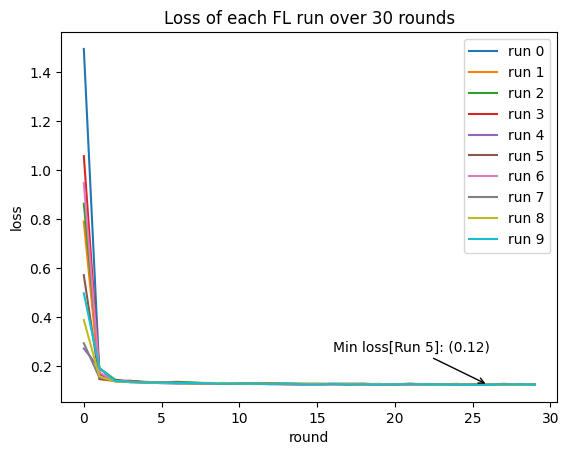

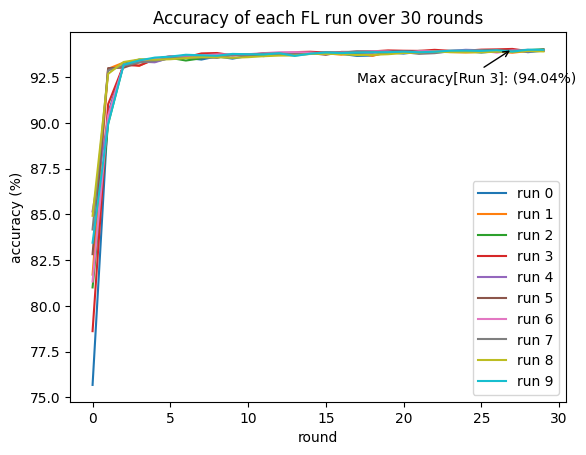

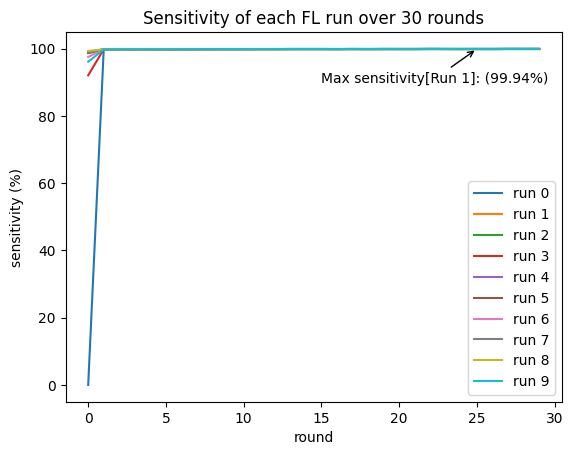

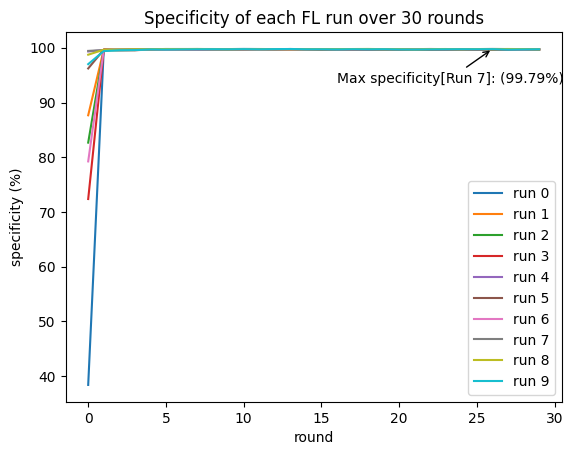

2023-08-24 21:29:38,570	WARNING worker.py:2019 -- Raylet is terminated: ip=172.19.27.35, id=fb7250dccc0ed7ee4f61a5c32336252fcd43bb189d37d4589bd717a8. Termination is unexpected. Possible reasons include: (1) SIGKILL by the user or system OOM killer, (2) Invalid memory access from Raylet causing SIGSEGV or SIGBUS, (3) Other termination signals. Last 20 lines of the Raylet logs:
    - num bytes created total: 21293661153
    0 pending objects of total size 0MB
    - objects spillable: 0
    - bytes spillable: 0
    - objects unsealed: 0
    - bytes unsealed: 0
    - objects in use: 0
    - bytes in use: 0
    - objects evictable: 0
    - bytes evictable: 0
    
    - objects created by worker: 0
    - bytes created by worker: 0
    - objects restored: 0
    - bytes restored: 0
    - objects received: 0
    - bytes received: 0
    - objects errored: 0
    - bytes errored: 0
    

(raylet) [2023-08-24 21:29:39,044 E 28576 28613] (raylet) agent_manager.cc:135: The raylet exited immediately b

In [153]:
plot_all(p_histories)

### Plot Time Taken

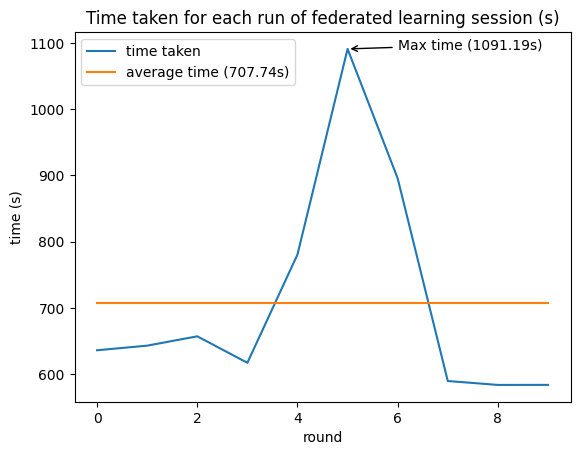

In [94]:
plt.figure('timetaken')
plt.title("Time taken for each run of federated learning session (s)")
avg = sum(times)/RUNS
max_t = max(times)
r = np.argmax(times) # Round number of the maximum
plt.plot(times, label='time taken')
plt.plot(np.full(shape=len(times), fill_value=(sum(times)/RUNS)), label=f'average time ({avg:.2f}s)')
plt.annotate(f'Max time ({max_t:.2f}s)', xy=(r, max_t), xytext=(r+1, max_t), arrowprops=dict(arrowstyle='->', lw=1))
plt.xlabel('round')
plt.ylabel('time (s)')
plt.legend()

In [ ]:
import pickle
import os

def load_model(path: str):
    try:
        with open(path, 'rb') as file:
            return pickle.load(file)
    except IOError:
        print(f"Error loading file at {path}")
        return None
    
# prm = load_model(os.path.abspath("../../model_ckpt/model_r3.ckpt"))


## Hashing

In [ ]:
client_param = fl.common.parameters_to_ndarrays(param_storer)
bytes_client_param = b''.join(fl.common.parameter.ndarrays_to_parameters(client_param).tensors)
server_param = b''.join(param_storer.tensors)
# client_1.evaluate(, {})

In [ ]:
import numpy as np
import math

arr = np.arange(20)

def part(nc, cid, df, overlap):
    n = len(df)
    offset = overlap/2.0
    div_len = n // nc
    start = max(0, int(cid * div_len - (n * offset))) - 1
    print("Start:", start)
    end = min(n - 1, int(cid * div_len + (offset * n)))
    print("End:", end)
    return df[start:] if cid == nc else df[start:end]

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view

sliding_window_view(arr, (1, 10), )

In [ ]:
nc = 3
part(nc, 1, arr, 0.5), part(nc, 2, arr, 0.5), part(nc, 3, arr, 0.5)